# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

## Problem Statement
My goal is find whether a customer is going to completed an offer or not given set of features

### Proccess of my approach:
* Data understanding.
* EDA ( Exploratory Data Analysis ) 
* Preprocessing features for modeling
* model building
* model optimizations

## Metrics:
For any classification problem accuracy is probably should'nt be your metric for evaluating your model but to use as in getting a sense of how your model is performing. For that reason my metric of measurement is precison. 

In [139]:
import pandas as pd
import numpy as np
import math
import json
% matplotlib inline
from IPython.display import display, HTML
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
display(HTML('<style>.container { width:100% !important; }</style>'))
import datetime
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import fbeta_score, accuracy_score, classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [28]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [134]:
# explore portofolio
display(portfolio.head())

,difficulty,duration,offer_type,reward,offer_id,web,email,mobile,social
0,10,7,bogo,10,1,0,1,1,1
1,10,5,bogo,10,2,1,1,1,1
2,0,4,informational,0,3,1,1,1,0
3,5,7,bogo,5,4,1,1,1,0
4,20,10,discount,5,5,1,1,0,0


channel needs to be processed to `4 columns`
mapping id to a number id

In [30]:
# id mapper helper
def id_mapper(data):
    '''
    id mapper funciton
    
    INPUT:
    data - type: DataFrame
    
    OUTPUT:
    ids - list: list of generated unique ids 
    
    '''
    coded_dict = dict()
    cter = 1
    id_encoded = []
    
    for val in data:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        id_encoded.append(coded_dict[val])
    return id_encoded

In [31]:
portfolio['offer_id'] = id_mapper(portfolio['id'])
del portfolio['id']

In [32]:
display(portfolio.head(2))

,channels,difficulty,duration,offer_type,reward,offer_id
0,"[email, mobile, social]",10,7,bogo,10,1
1,"[web, email, mobile, social]",10,5,bogo,10,2


In [33]:
# extract channels list values to column.
portfolio['web'] = portfolio['channels'].apply(lambda x: 1 if 'web' in x else 0)
portfolio['email'] = portfolio['channels'].apply(lambda x: 1 if 'email' in x else 0)
portfolio['mobile'] = portfolio['channels'].apply(lambda x: 1 if 'mobile' in x else 0)
portfolio['social'] = portfolio['channels'].apply(lambda x: 1 if 'social' in x else 0)
del portfolio['channels']

In [34]:
portfolio.head(1)

,difficulty,duration,offer_type,reward,offer_id,web,email,mobile,social
0,10,7,bogo,10,1,0,1,1,1


In [35]:
portfolio.shape

(10, 9)

In [36]:
# checking missing values
# null values per columns
portfolio.isna().sum(axis=0)

difficulty    0
duration      0
offer_type    0
reward        0
offer_id      0
web           0
email         0
mobile        0
social        0
dtype: int64

In [37]:
# null values per rows
portfolio.isna().sum(axis=1).sum()

0

In [38]:
portfolio['offer_type'].unique()

array(['bogo', 'informational', 'discount'], dtype=object)

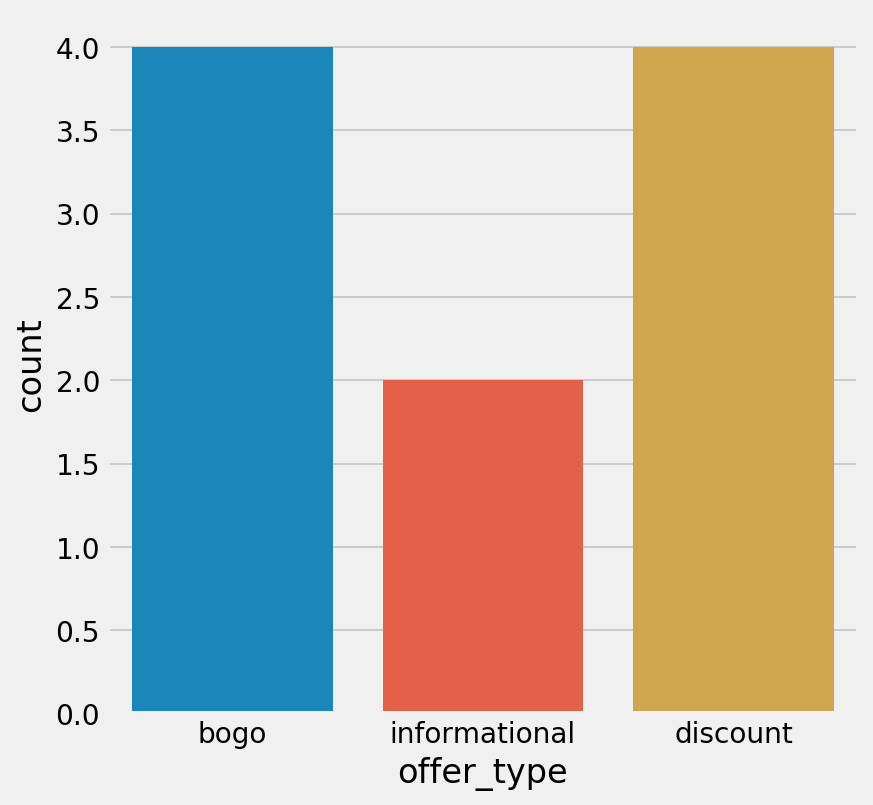

In [39]:
plt.figure(figsize=(6, 6))
sns.countplot(portfolio.offer_type);

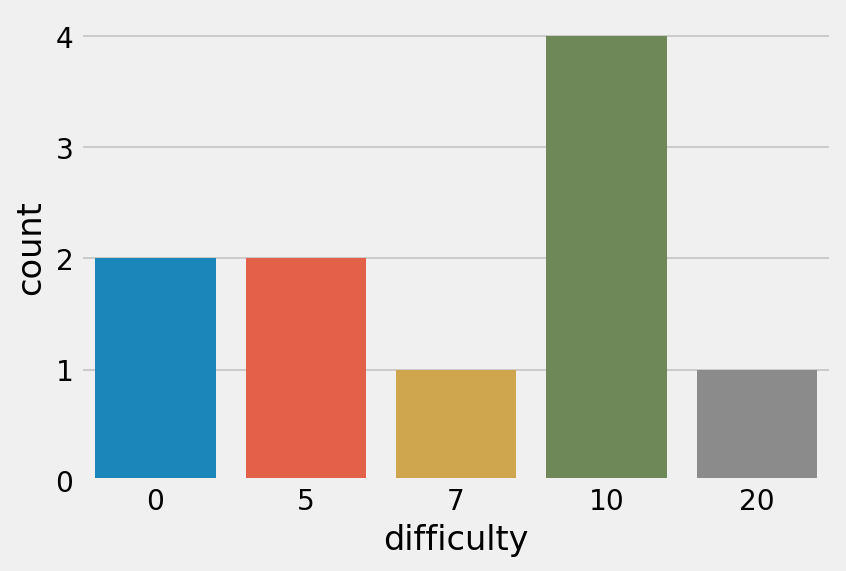

In [40]:
# difficulty distribution 
sns.countplot(portfolio.difficulty);

it seems the dominant offer duration is `10` days 

In [41]:
# exploring profile - customer demo. set
display(profile.head(2))
print(profile.shape)

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0


(17000, 5)


We also need to map id to an id number

In [42]:

profile['customer_id'] = id_mapper(profile['id'])
del profile['id']

In [43]:
profile.head(1)

,age,became_member_on,gender,income,customer_id
0,118,20170212,None,NaN,1


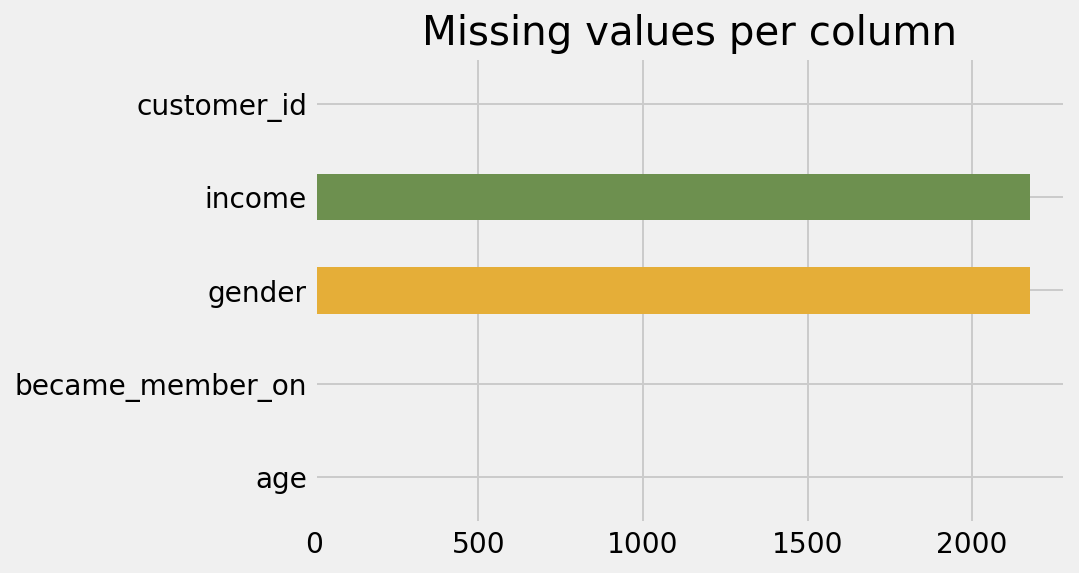

In [44]:
profile.isna().sum(axis=0).plot(kind='barh', );
plt.title('Missing values per column');
plt.show();


In [45]:
profile.loc[profile.gender=='M'].income.mean()

61194.601603017443

In [46]:
profile.loc[profile.gender=='F'].income.mean()

71306.412139011256

In [47]:
profile.age.mean()

62.531411764705879

In [124]:
profile.income.mean()

65404.991568296799

In [48]:
# missing values per rows
profile.isna().sum(axis=1).sum()

4350

In [49]:
profile.loc[profile.isna().sum(axis=1) > 1].shape

(2175, 5)

it seems nearly half of the missing values are in both of the income and age

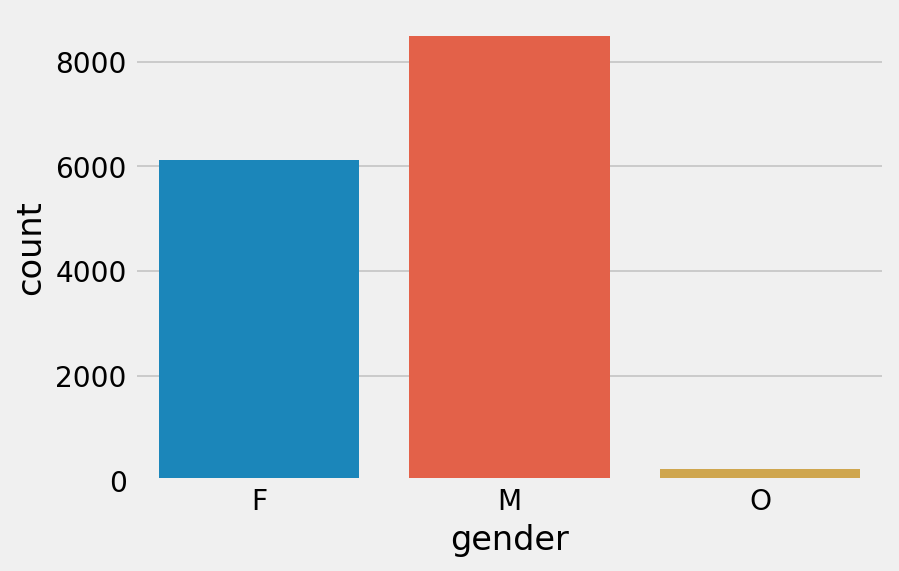

In [50]:
sns.countplot(profile.gender);

We have more demographic information on `Males` than `Female`. and `othesrs`.

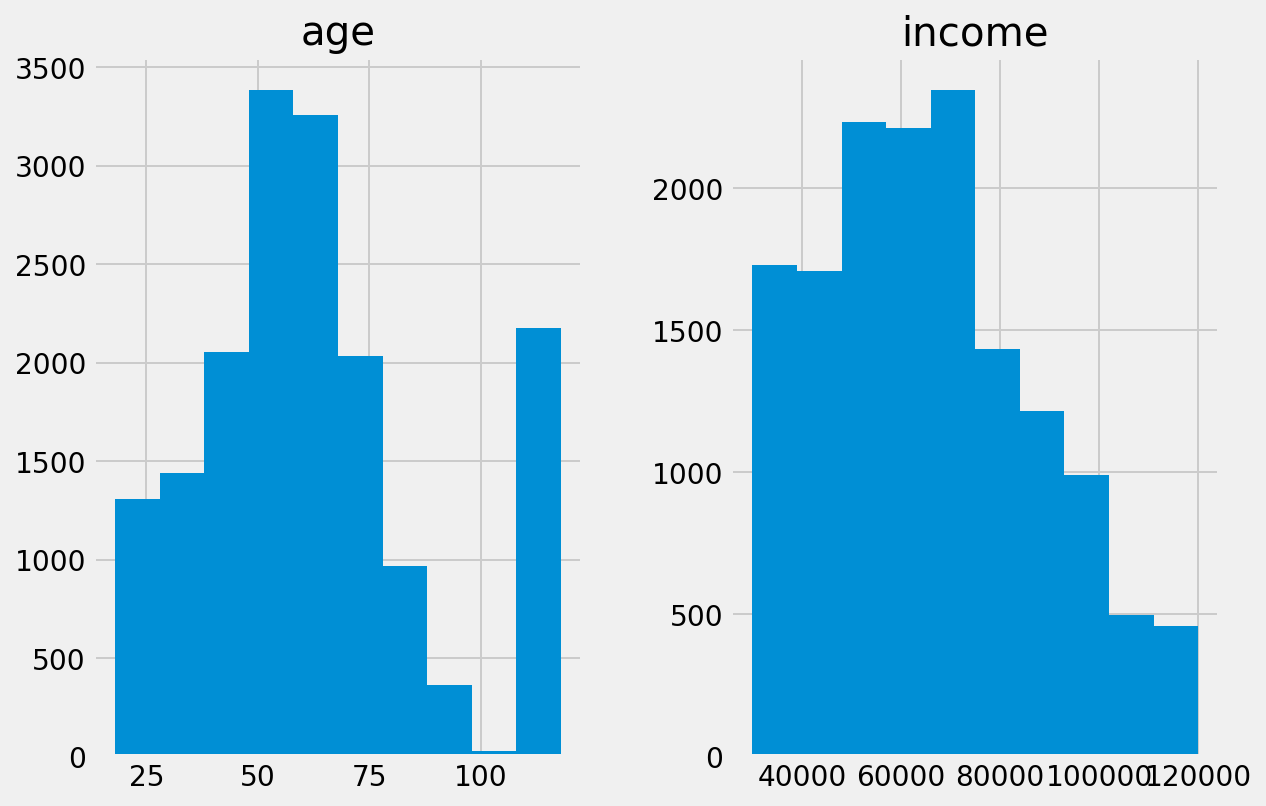

In [51]:
profile[['age', 'income']].hist(figsize=(9, 6));

By looking at the age hist we can notice there outliers with age nearly `110` 
we need to investiage it further.

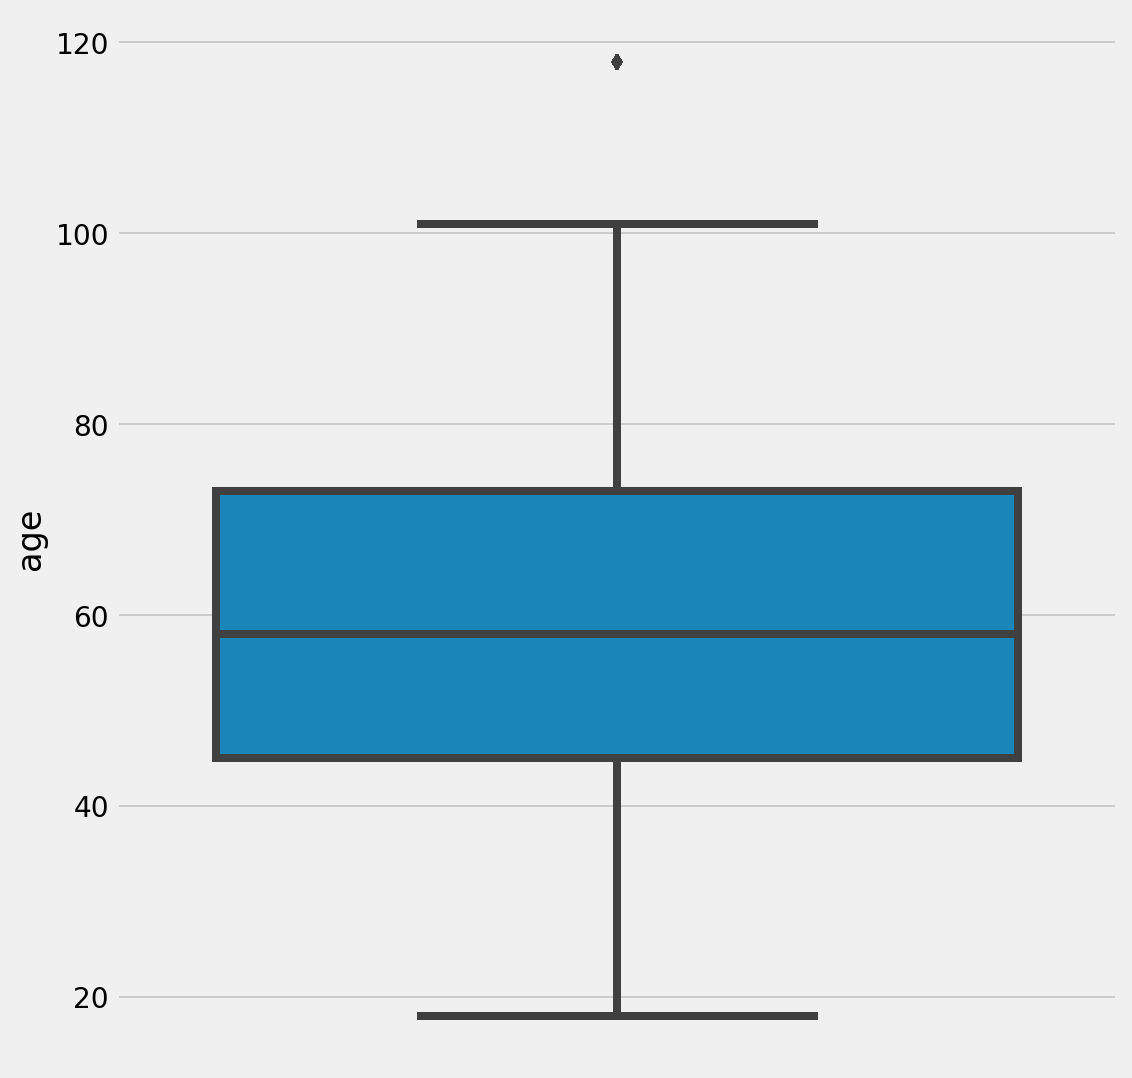

In [52]:
plt.figure(figsize=(8, 9))
sns.boxplot(profile['age'], orient='v');

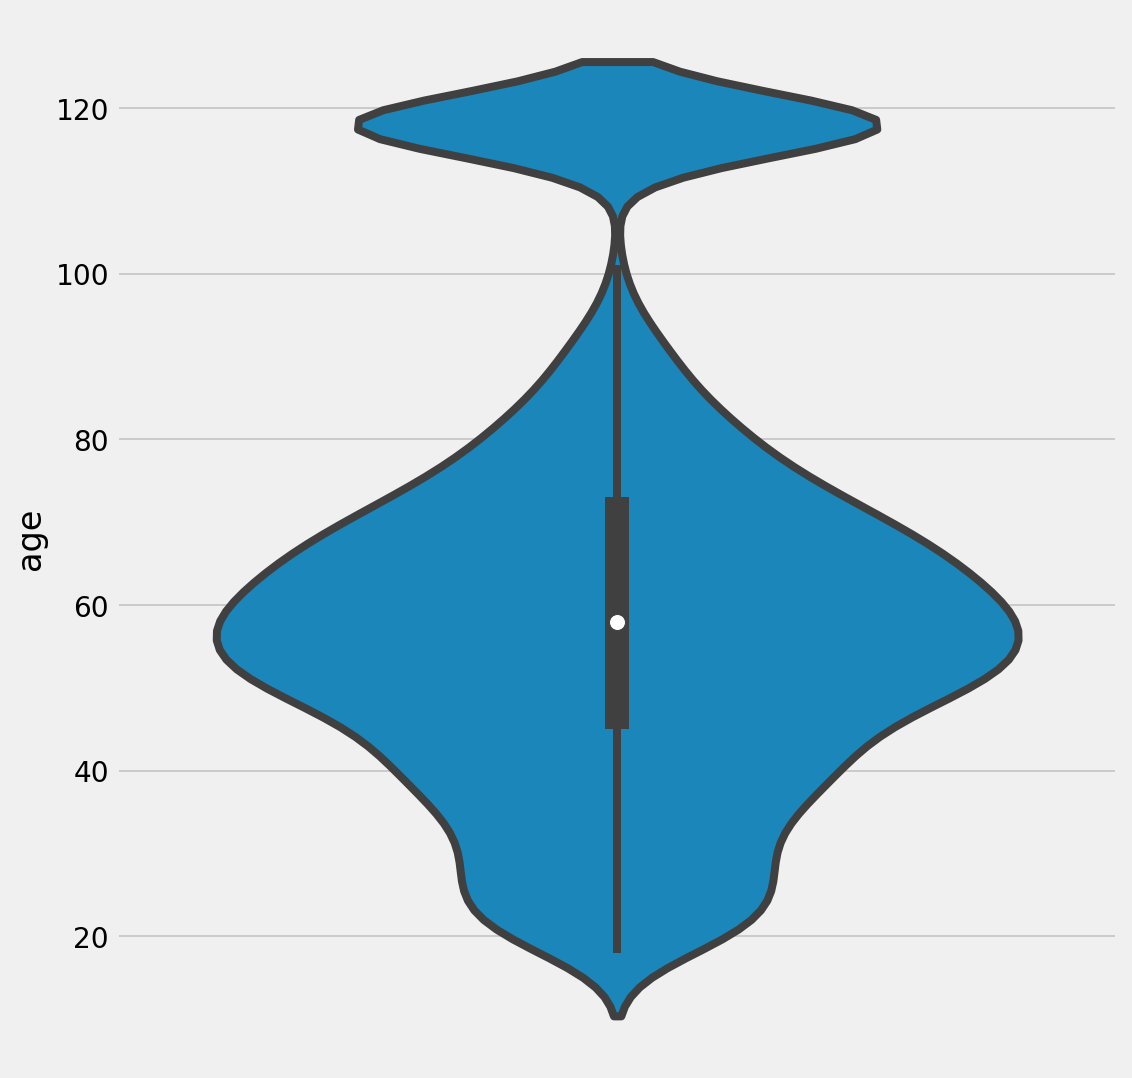

In [53]:
plt.figure(figsize=(8, 9))
sns.violinplot(profile['age'], orient='v' );

In [54]:
# it seems this age has all the missing values
profile.loc[profile.age ==118].isna().sum(), print(profile.isna().sum())

age                    0
became_member_on       0
gender              2175
income              2175
customer_id            0
dtype: int64


(age                    0
 became_member_on       0
 gender              2175
 income              2175
 customer_id            0
 dtype: int64, None)

In [55]:
profile.drop(profile.loc[profile.age ==118].index, inplace=True)

By looking at the the two figures above we can clearly notice there are outliers with age close to 120, Also there are a significant number of them

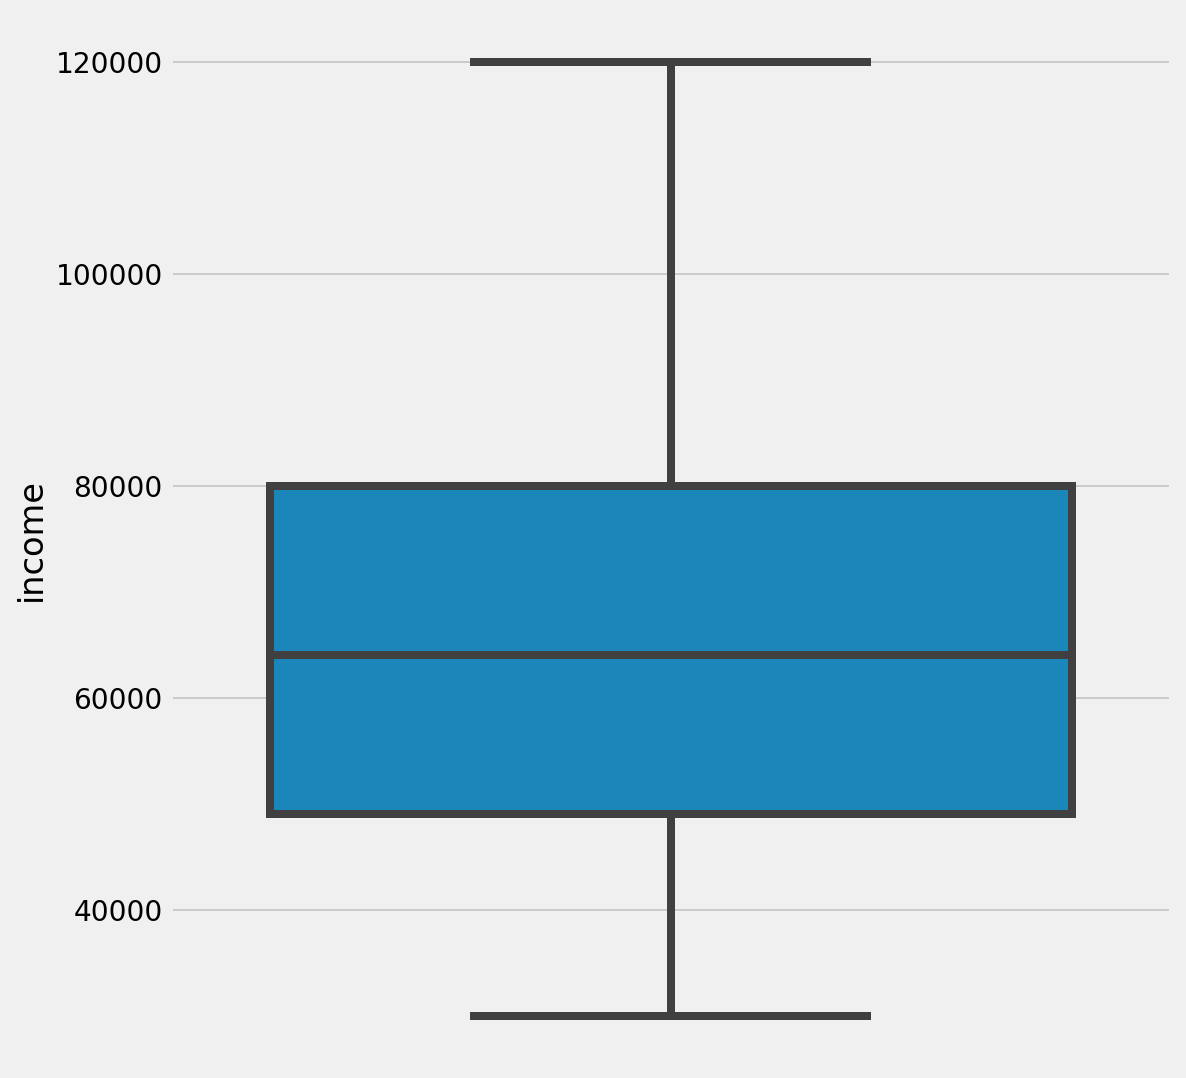

In [56]:
plt.figure(figsize=(8, 9))
sns.boxplot(profile['income'], orient='v');

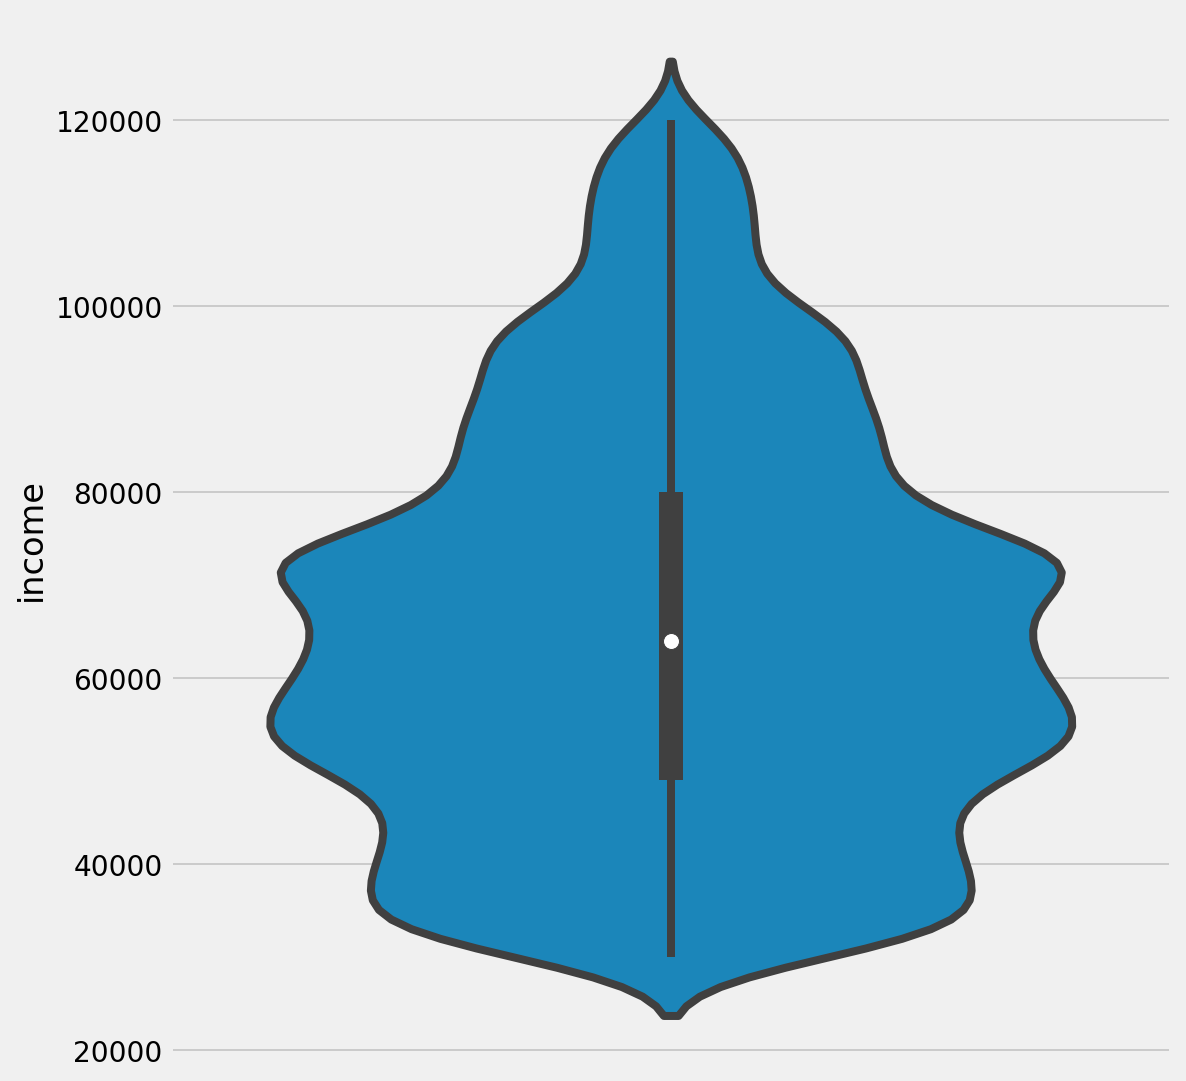

In [57]:
plt.figure(figsize=(8, 9))
sns.violinplot(profile['income'], orient='v');

Good to notice that there are no oulier. in income but is it realy!
Now i want to the distrubtion of income and age for each genders

In [58]:
# coparing by grouping 
def make_plots(groupof, data=profile):
    '''
    box plot and violin plots helper function 
    
    INPUT:
    groupof - the target to visulize
    
    OUTPUT:
    None - it plots 4 plots: 2 box plots 2 violinplots
    
    '''
    fig, axs = plt.subplots(2, 2, figsize=(11, 12))
    
    # first column
    sns.boxplot(profile.loc[profile.gender == groupof]['income'], orient='v', ax=axs[0][0]);
    sns.violinplot(profile.loc[profile.gender == groupof]['income'], orient='v', ax=axs[0][1]);

    # second column
    sns.boxplot(profile.loc[profile.gender== groupof]['age'], orient='v', ax=axs[1][0]);
    sns.violinplot(profile.loc[profile.gender== groupof]['age'], orient='v', ax=axs[1][1]);
    
    mid = (fig.subplotpars.right + fig.subplotpars.left)/2
    plt.tight_layout()
    plt.suptitle(groupof, fontsize=25, x=mid + 0.04) 
    plt.subplots_adjust(top=0.91)
    plt.show()
    pass

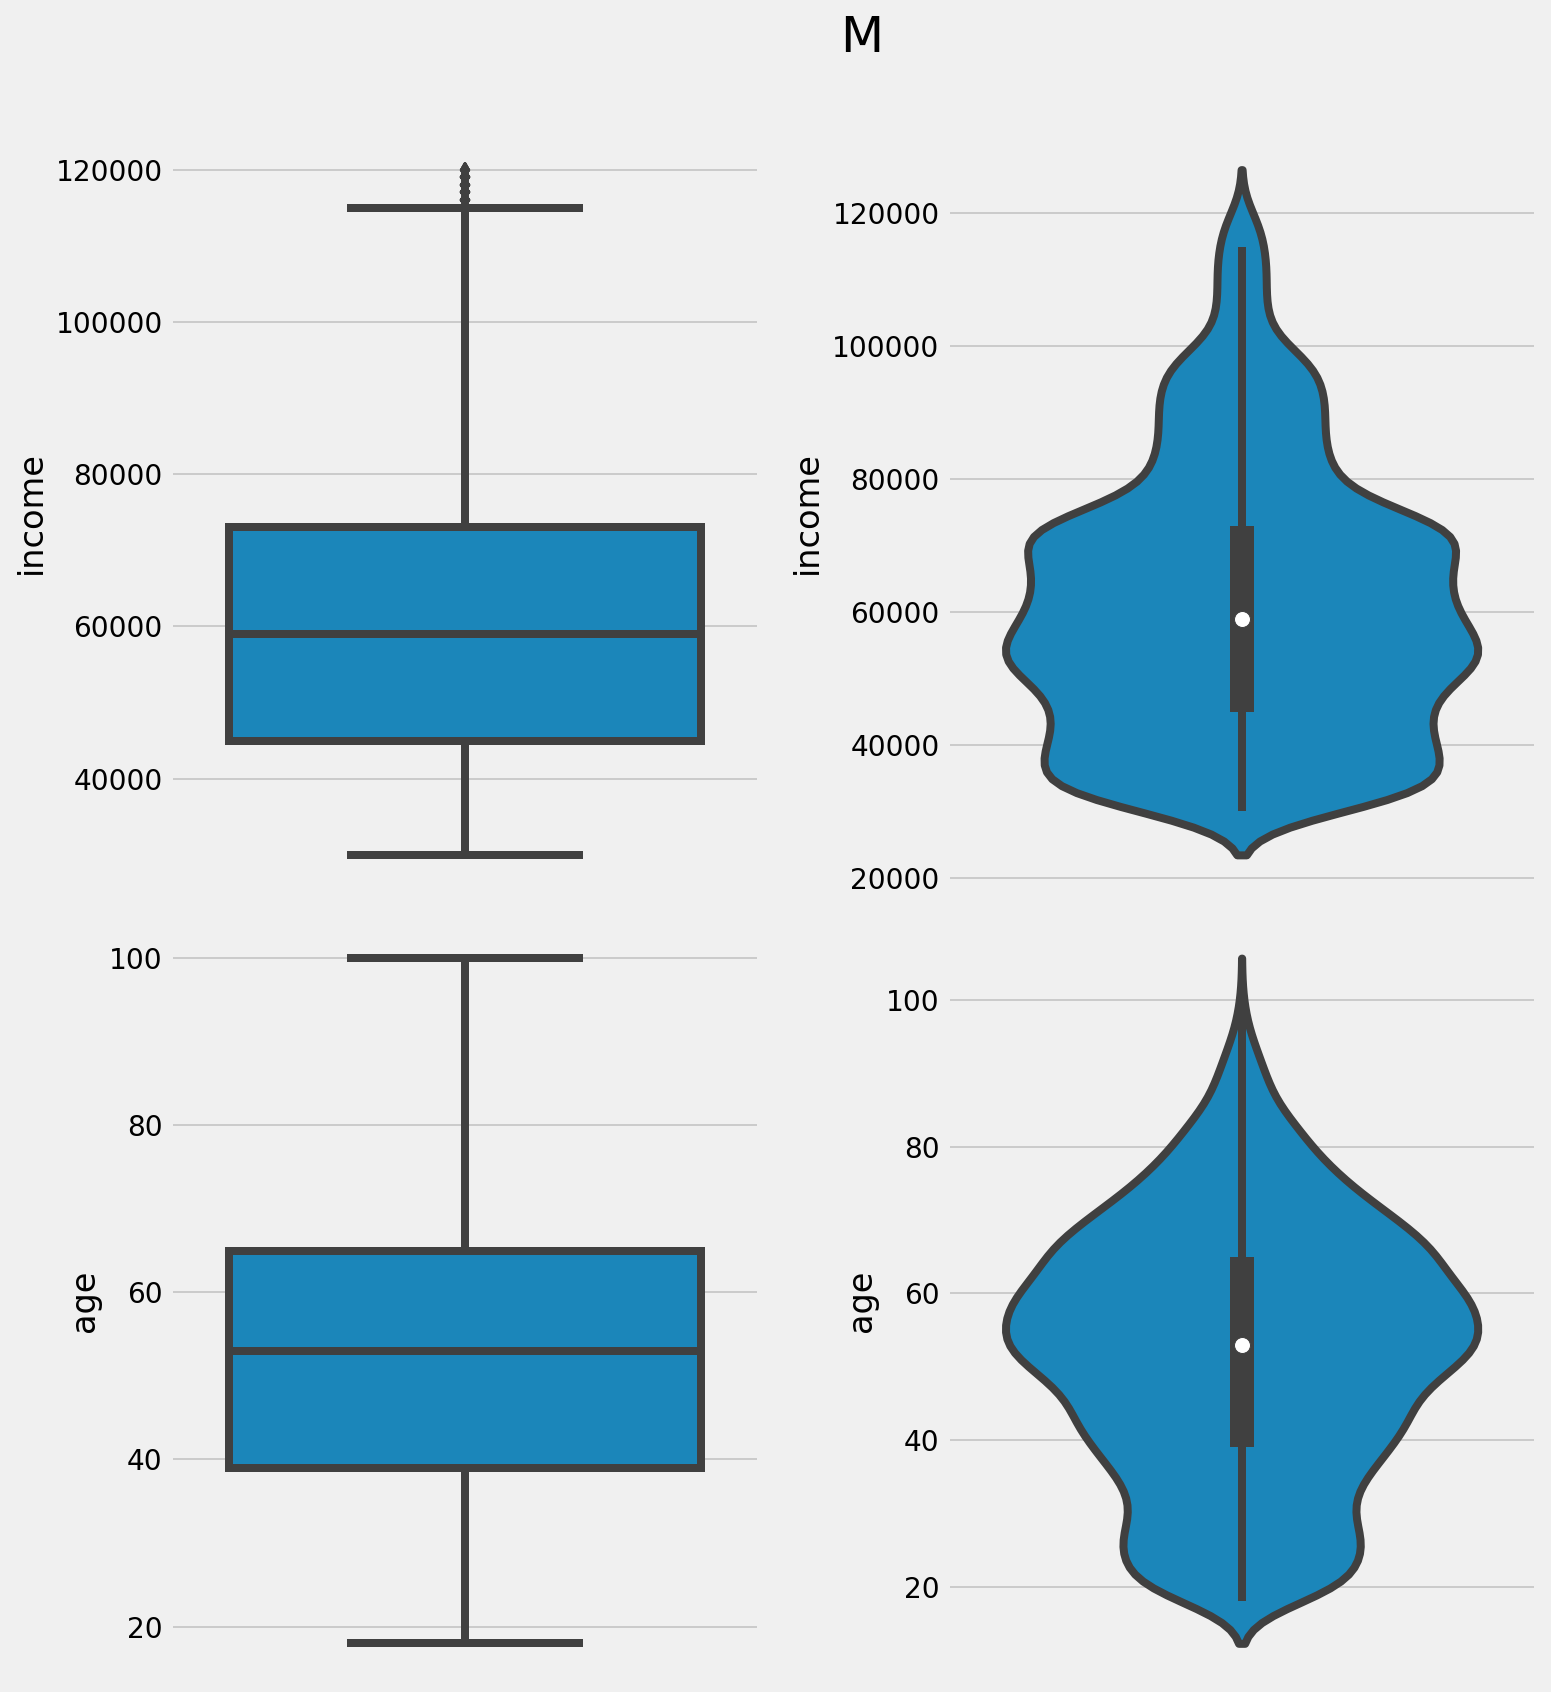

In [59]:
make_plots('M')

it seems for income of males majority of them have income ranges from roughly 50K to 70K. with few with income closeto 120K

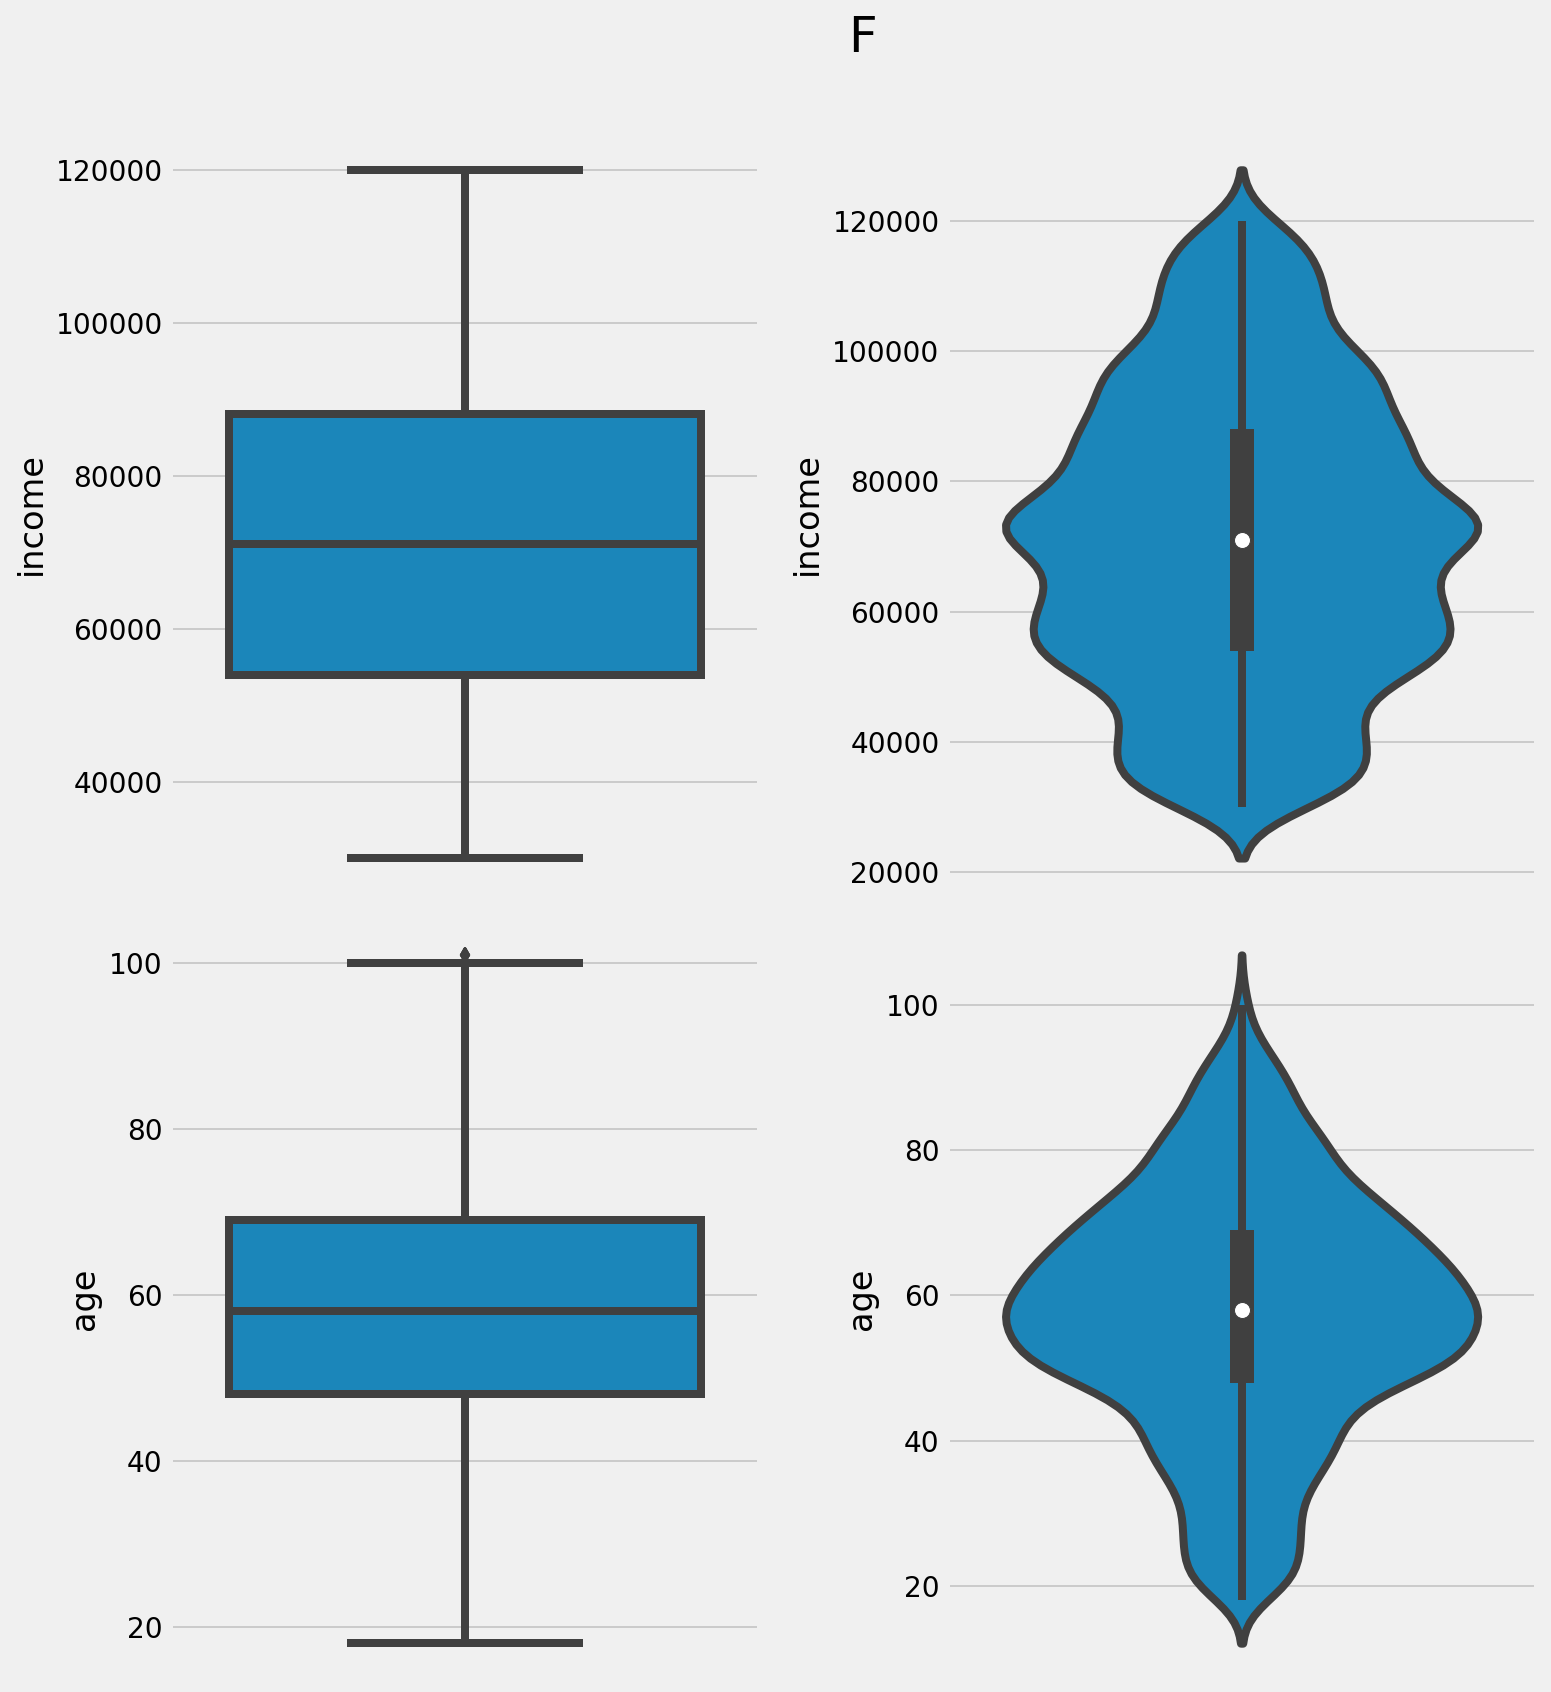

In [60]:
make_plots('F')

There are outliers in female in income

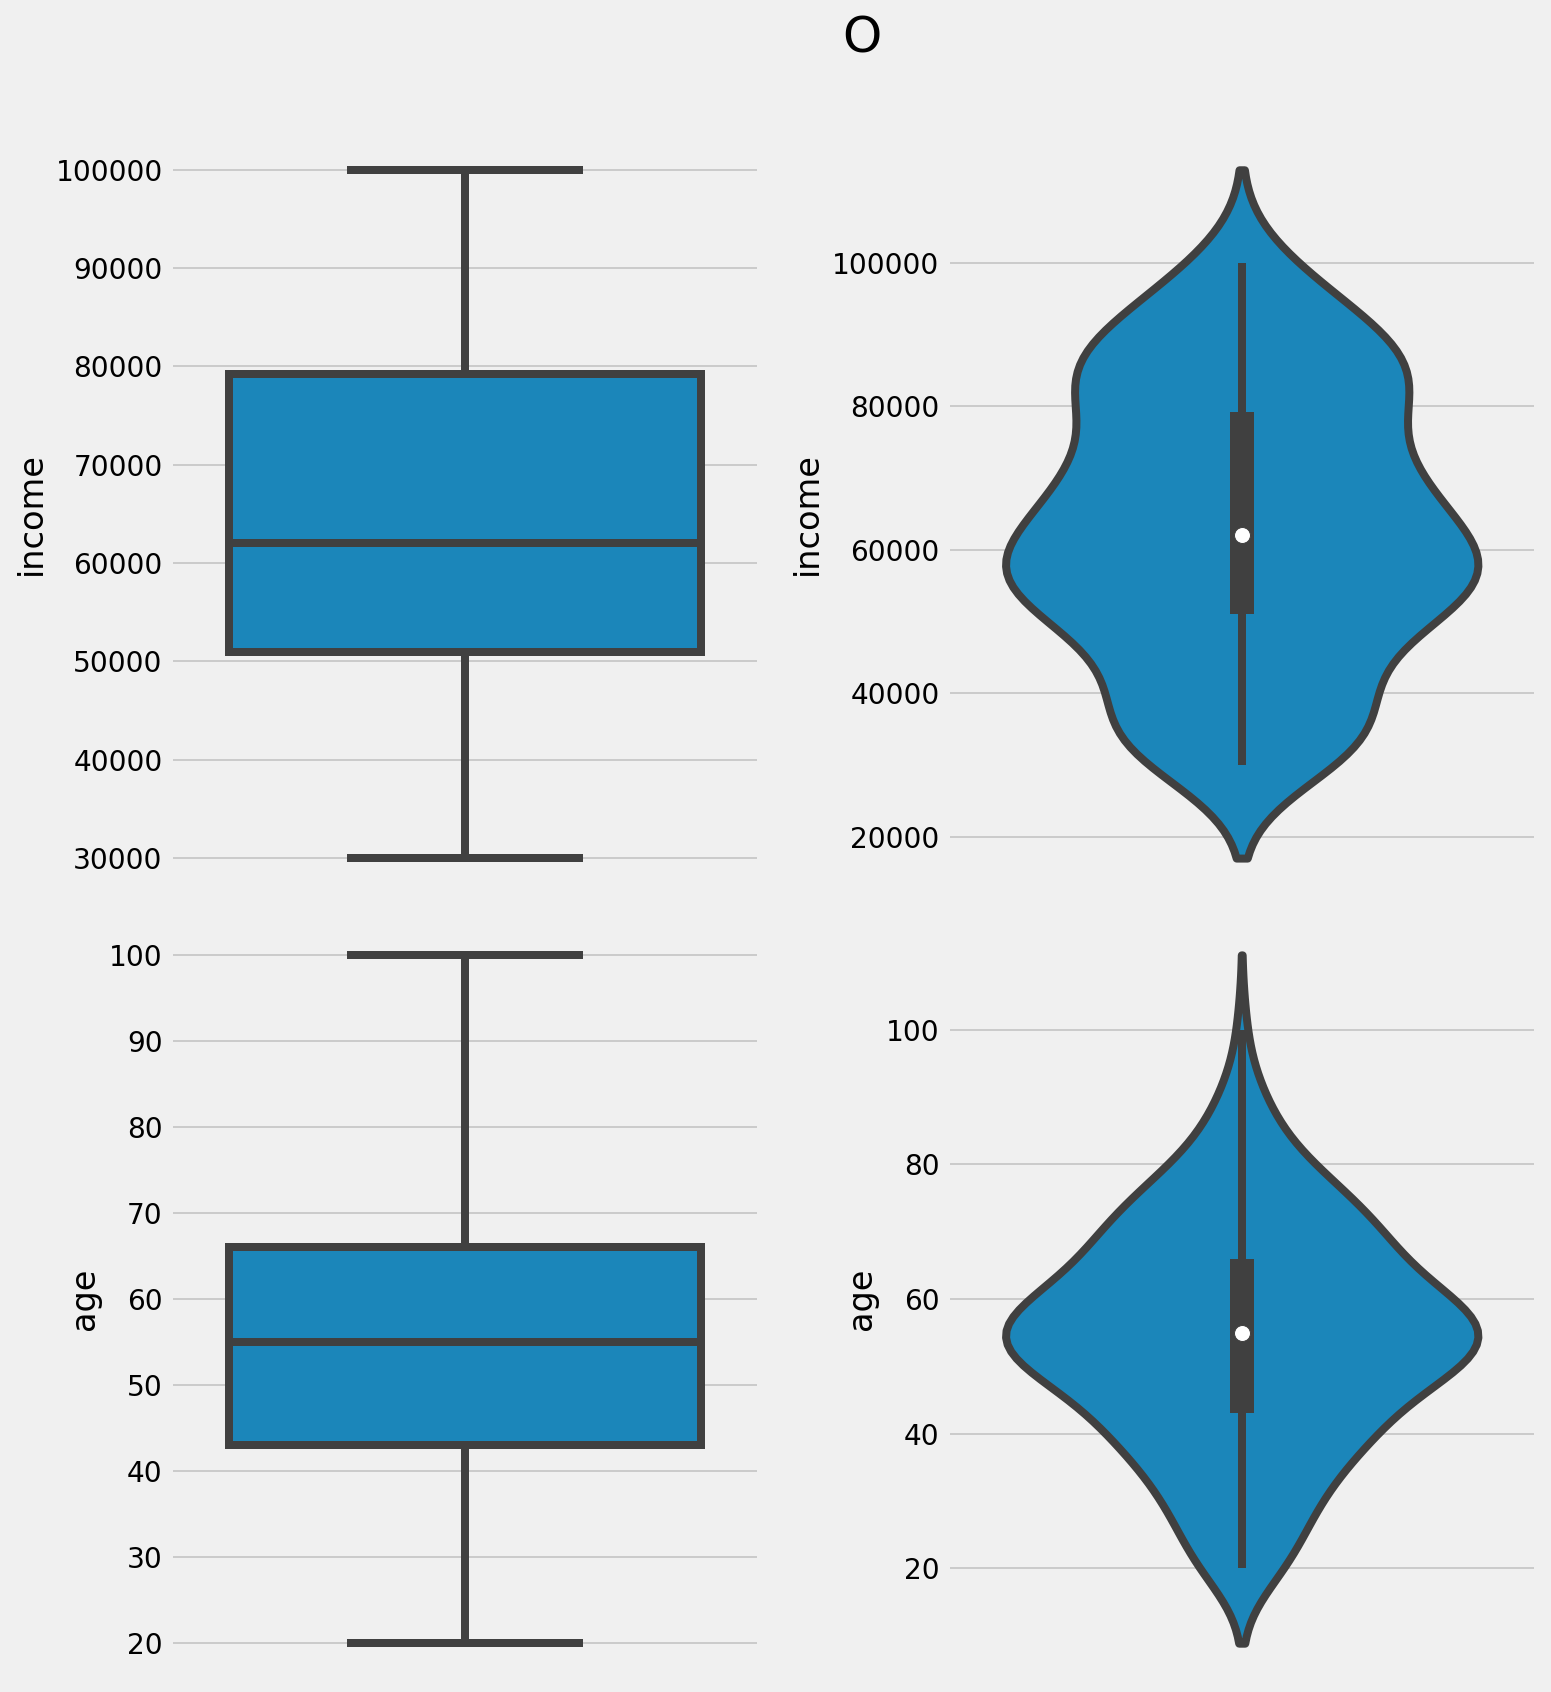

In [61]:
make_plots('O')

It seems that the there only outiler in income for males
We will dell with these outliers later.

In [62]:
# exploring transript
display(transcript.head(2))

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}


We also need a mapper for person and rename it to match the customer id in profile

In [63]:
transcript['customer_id'] = id_mapper(transcript['person'])
del transcript['person']

In [64]:
transcript.head(2)

,event,time,value,customer_id
0,offer received,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},1
1,offer received,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},2


We also need to address the offer id in value

In [65]:
transcript.value.sample(50)

219255     {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
255704     {'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
273234                                      {'amount': 6.9}
234366                                     {'amount': 0.24}
131007     {'offer id': '2906b810c7d4411798c6938adc9daaa5'}
22263                                      {'amount': 6.47}
270006                                     {'amount': 1.88}
21303     {'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2...
687        {'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
234779                                    {'amount': 19.96}
222082     {'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
95106                                      {'amount': 7.62}
246876     {'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
103535                                     {'amount': 5.35}
239096                                    {'amount': 12.01}
224046    {'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...
48401      {'offer id': '3f207df678b143e

In [66]:
transcript.loc[transcript.event =='transaction'].value.sample(100)

269096                  {'amount': 6.94}
297458                  {'amount': 7.67}
106754                 {'amount': 16.32}
26516                    {'amount': 1.1}
223833                  {'amount': 1.44}
36409                   {'amount': 2.41}
233176                 {'amount': 22.14}
180645                  {'amount': 15.4}
144793                 {'amount': 12.18}
136215                  {'amount': 1.82}
143913                 {'amount': 13.49}
127496                 {'amount': 30.97}
174125                  {'amount': 3.98}
301076                  {'amount': 20.5}
199101                  {'amount': 33.9}
149899                  {'amount': 30.1}
305871                 {'amount': 20.89}
231658    {'amount': 5.5600000000000005}
101284                 {'amount': 29.62}
109003                  {'amount': 1.34}
186318                  {'amount': 16.9}
286594                  {'amount': 0.93}
266294                  {'amount': 0.64}
136207                 {'amount': 12.57}
236745          

as suspected events with transaction as their value doesn't have offer is in the value
and it seems some values named offer_id and offer id which needs to be addressed


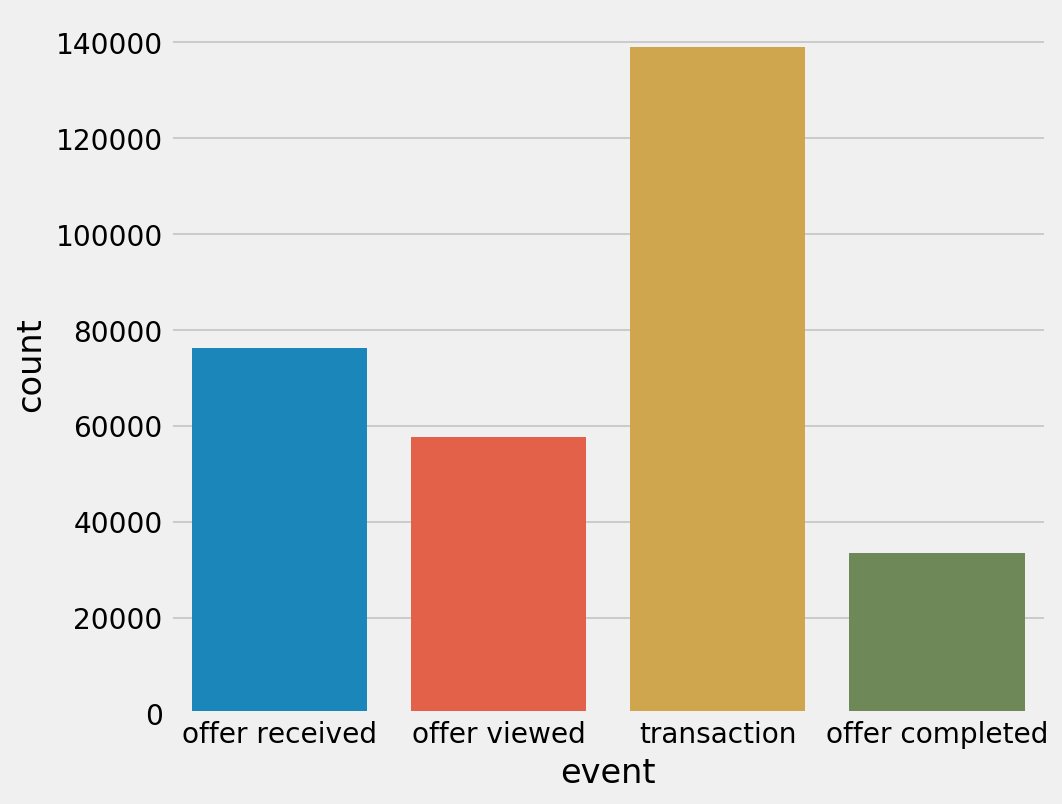

In [67]:
plt.figure(figsize=(7,6))
sns.countplot(transcript.event);

we can notice the decline in offer sent and viewed to complete.

In [68]:
# extracting the values in value column 
values = pd.DataFrame([x for x in transcript['value']])

In [69]:
values.head(2)

,amount,offer id,offer_id,reward
0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
1,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN


In [70]:
values.shape, transcript.shape

((306534, 4), (306534, 4))

In [71]:
transcript = pd.concat([transcript, values], axis=1, sort=False)

In [72]:
display(transcript.head(5))

,event,time,value,customer_id,amount,offer id,offer_id,reward
0,offer received,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},1,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
1,offer received,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},2,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN
2,offer received,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},3,NaN,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
3,offer received,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},4,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
4,offer received,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},5,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN


In [73]:
transcript.loc[transcript.event =='transaction'].head() 

,event,time,value,customer_id,amount,offer id,offer_id,reward
12654,transaction,0,{'amount': 0.8300000000000001},28,0.83,NaN,NaN,NaN
12657,transaction,0,{'amount': 34.56},37,34.56,NaN,NaN,NaN
12659,transaction,0,{'amount': 13.23},12651,13.23,NaN,NaN,NaN
12670,transaction,0,{'amount': 19.51},6658,19.51,NaN,NaN,NaN
12671,transaction,0,{'amount': 18.97},108,18.97,NaN,NaN,NaN


In [74]:
transcript.amount.describe()

count    138953.000000
mean         12.777356
std          30.250529
min           0.050000
25%           2.780000
50%           8.890000
75%          18.070000
max        1062.280000
Name: amount, dtype: float64

In [75]:
del transcript['value']

In [76]:
# now we map offer id 

In [77]:
transcript['combined_offers'] = [i for i in zip(transcript["offer_id"],transcript["offer id"])]   

In [78]:
def helper(x):
    for i in x:
        if isinstance(i, str):
            return i


In [79]:
offer_id = transcript.combined_offers.apply(helper)
del transcript['offer_id']
del transcript['offer id']
del transcript['combined_offers']

In [80]:
offer_id = id_mapper(offer_id)
transcript['offer_id'] = offer_id

In [81]:
display(transcript.head(2))

,event,time,customer_id,amount,reward,offer_id
0,offer received,0,1,NaN,NaN,1
1,offer received,0,2,NaN,NaN,2


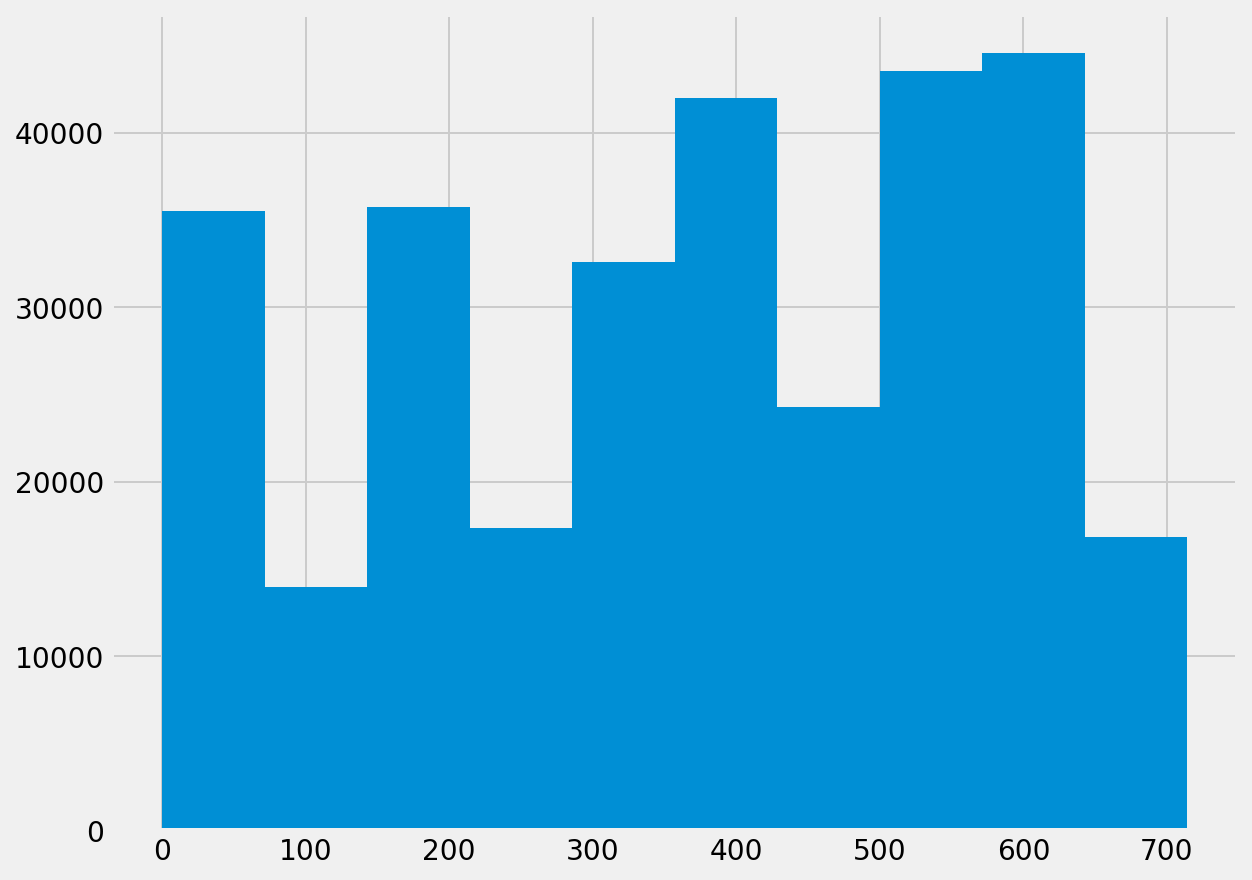

In [82]:
transcript.time.hist(figsize=(9, 7));

In [83]:
transcript.reward.describe()

count    33579.000000
mean         4.904137
std          2.886647
min          2.000000
25%          2.000000
50%          5.000000
75%          5.000000
max         10.000000
Name: reward, dtype: float64

Now that we finished exploring the data let's try to create more features and see some patterns
for example in age i will combine in it into grouped **[ages teenager - young - adult ..]**
- create a range for income
> * average (30,000 - 60,000]
> * above-average (60,0000 - 90,000]
> * high (90,000, ∞]

In [84]:
profile_copy = profile.copy()
portfolio_copy = portfolio.copy()
transcript_copy = transcript.copy()

In [85]:
profile_copy['age_group'] = pd.cut(profile_copy['age'], bins=[17, 22, 35, 60, 103],labels=['teenager', 'young-adult', 'adult', 'elderly'])

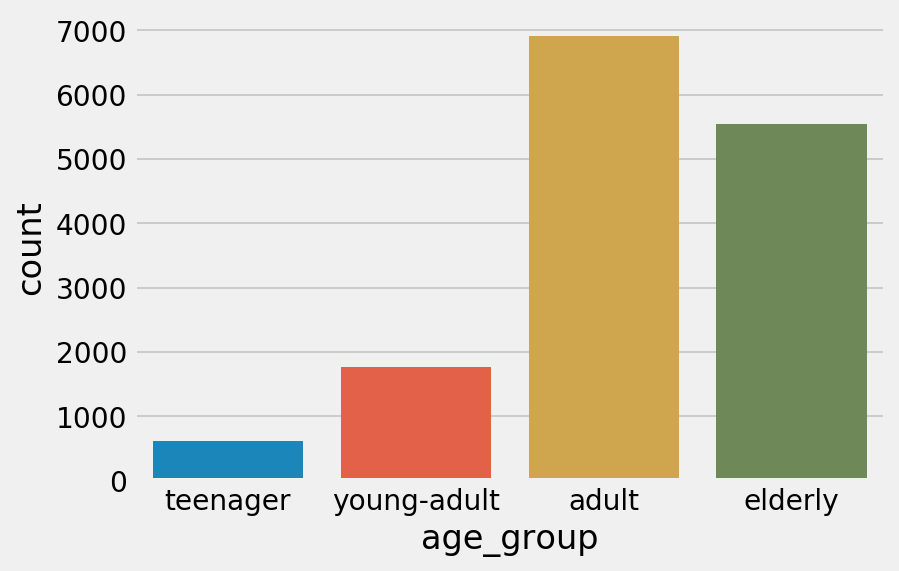

In [86]:
sns.countplot(profile_copy.age_group);

In [87]:
profile_copy['income_range'] = pd.cut(profile_copy['income'], bins=[29999, 60000, 90000, 120001],labels=['average', 'above-average', 'high'])

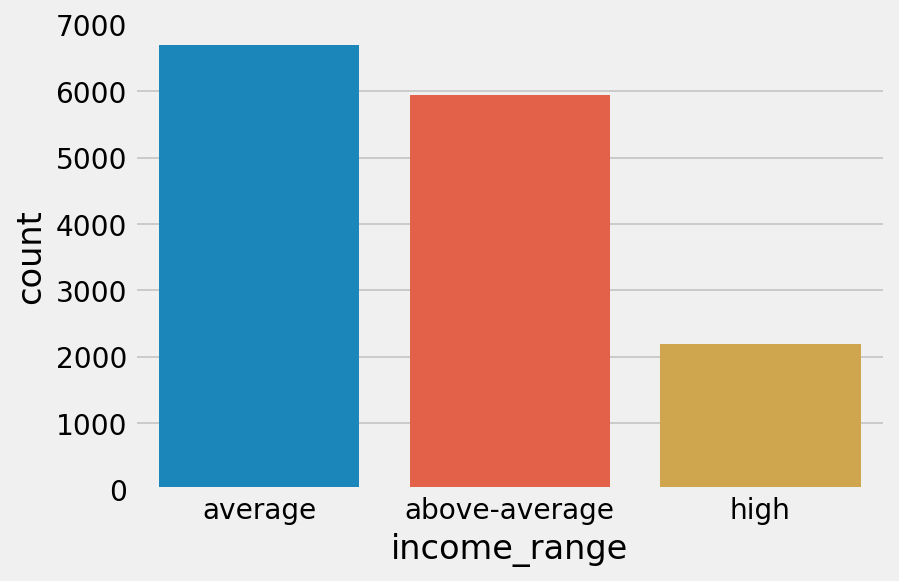

In [88]:
sns.countplot(profile_copy.income_range);

In [89]:
profile_copy['became_member_on'] = pd.to_datetime(profile_copy['became_member_on'], format = '%Y%m%d')

In [90]:
profile_copy['membership_year'] = profile_copy['became_member_on'].dt.year

In [91]:
profile_copy['membership_days'] = datetime.datetime.today().date() - profile_copy['became_member_on'].dt.date
profile_copy['membership_days'] = profile_copy['membership_days'].dt.days

In [92]:
profile_copy['member_type'] = pd.cut(profile_copy['membership_days'], bins=[390, 1000, 1600, 2500],labels=['new', 'regular', 'loyal'])

In [93]:
profile_copy.drop(columns=['became_member_on', 'membership_days'], axis=1, inplace=True)

In [94]:
display(profile_copy.head(2))

,age,gender,income,customer_id,age_group,income_range,membership_year,member_type
1,55,F,112000.0,2,adult,high,2017,new
3,75,F,100000.0,4,elderly,high,2017,regular


In [95]:
# Now pre-processing transcript

In [96]:
transcript_copy.rename(columns={'time':'time_h'},inplace=True)

In [97]:
transcript_copy.head()

,event,time_h,customer_id,amount,reward,offer_id
0,offer received,0,1,NaN,NaN,1
1,offer received,0,2,NaN,NaN,2
2,offer received,0,3,NaN,NaN,3
3,offer received,0,4,NaN,NaN,4
4,offer received,0,5,NaN,NaN,5


In [98]:
# i am only intrested in customer who viewed an offer and completed it there i will remove trasaction and offer recieved fron the event
# transcript_copy = transcript_copy.loc[(transcript_copy.event != 'transaction') & (transcript_copy.event != 'offer received')  ]

In [99]:
# Now pre-processing portfolio
portfolio_copy['duration'] = portfolio_copy['duration']*24 # changing unit from days to hours

In [100]:
portfolio_copy.rename(columns={'duration':'duration_h'},inplace=True)

In [101]:
df =transcript_copy.merge(portfolio_copy,how='inner',on='offer_id')

In [102]:
df = df.merge(profile_copy,how ='inner', on = 'customer_id')

In [103]:
display(df.head())

,event,time_h,customer_id,amount,reward_x,offer_id,difficulty,duration_h,offer_type,reward_y,...,email,mobile,social,age,gender,income,age_group,income_range,membership_year,member_type
0,offer received,0,19,NaN,NaN,1,10,168,bogo,10,...,1,1,1,57,M,42000.0,adult,average,2017,new
1,offer received,576,19,NaN,NaN,1,10,168,bogo,10,...,1,1,1,57,M,42000.0,adult,average,2017,new
2,offer viewed,714,19,NaN,NaN,1,10,168,bogo,10,...,1,1,1,57,M,42000.0,adult,average,2017,new
3,offer received,408,19,NaN,NaN,3,0,96,informational,0,...,1,1,0,57,M,42000.0,adult,average,2017,new
4,offer viewed,420,19,NaN,NaN,3,0,96,informational,0,...,1,1,0,57,M,42000.0,adult,average,2017,new


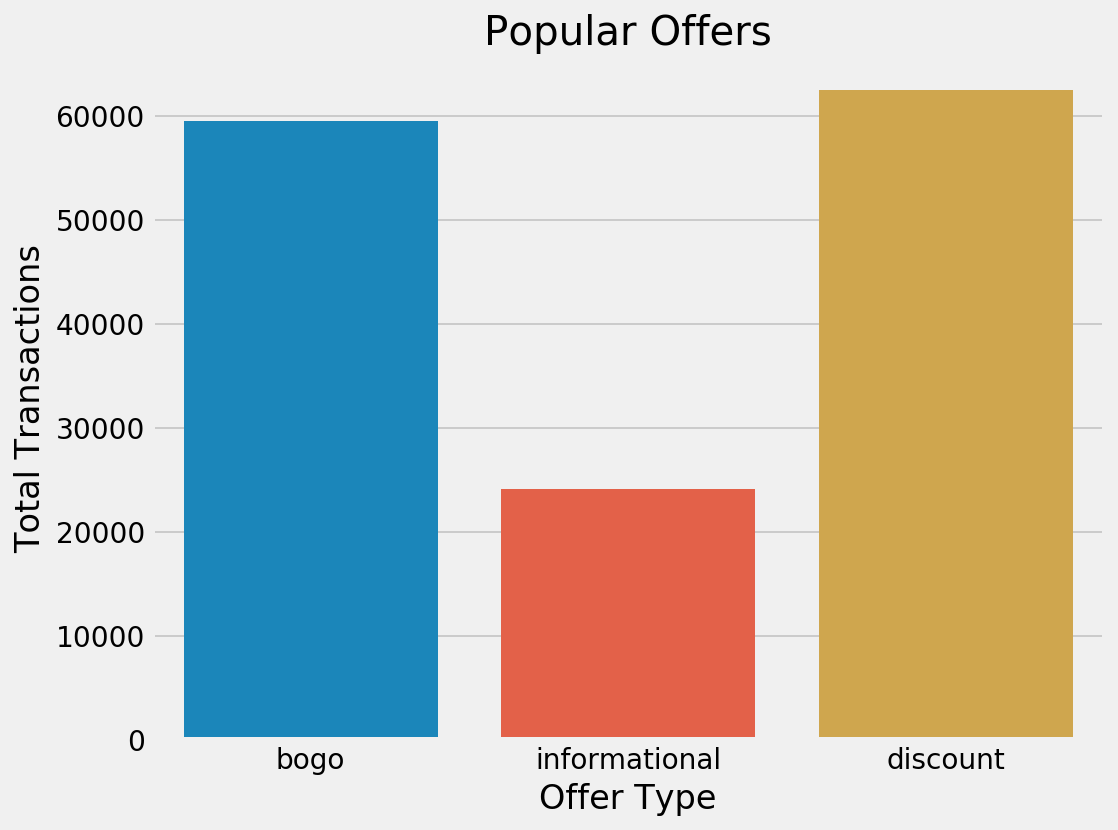

In [122]:
plt.figure(figsize=(8, 6))

plot = sns.countplot(df.offer_type)

plt.title('Popular Offers')



plt.ylabel('Total Transactions')
plt.xlabel('Offer Type')

plt.xticks(rotation = 0)


plt.tight_layout()
plt.show();

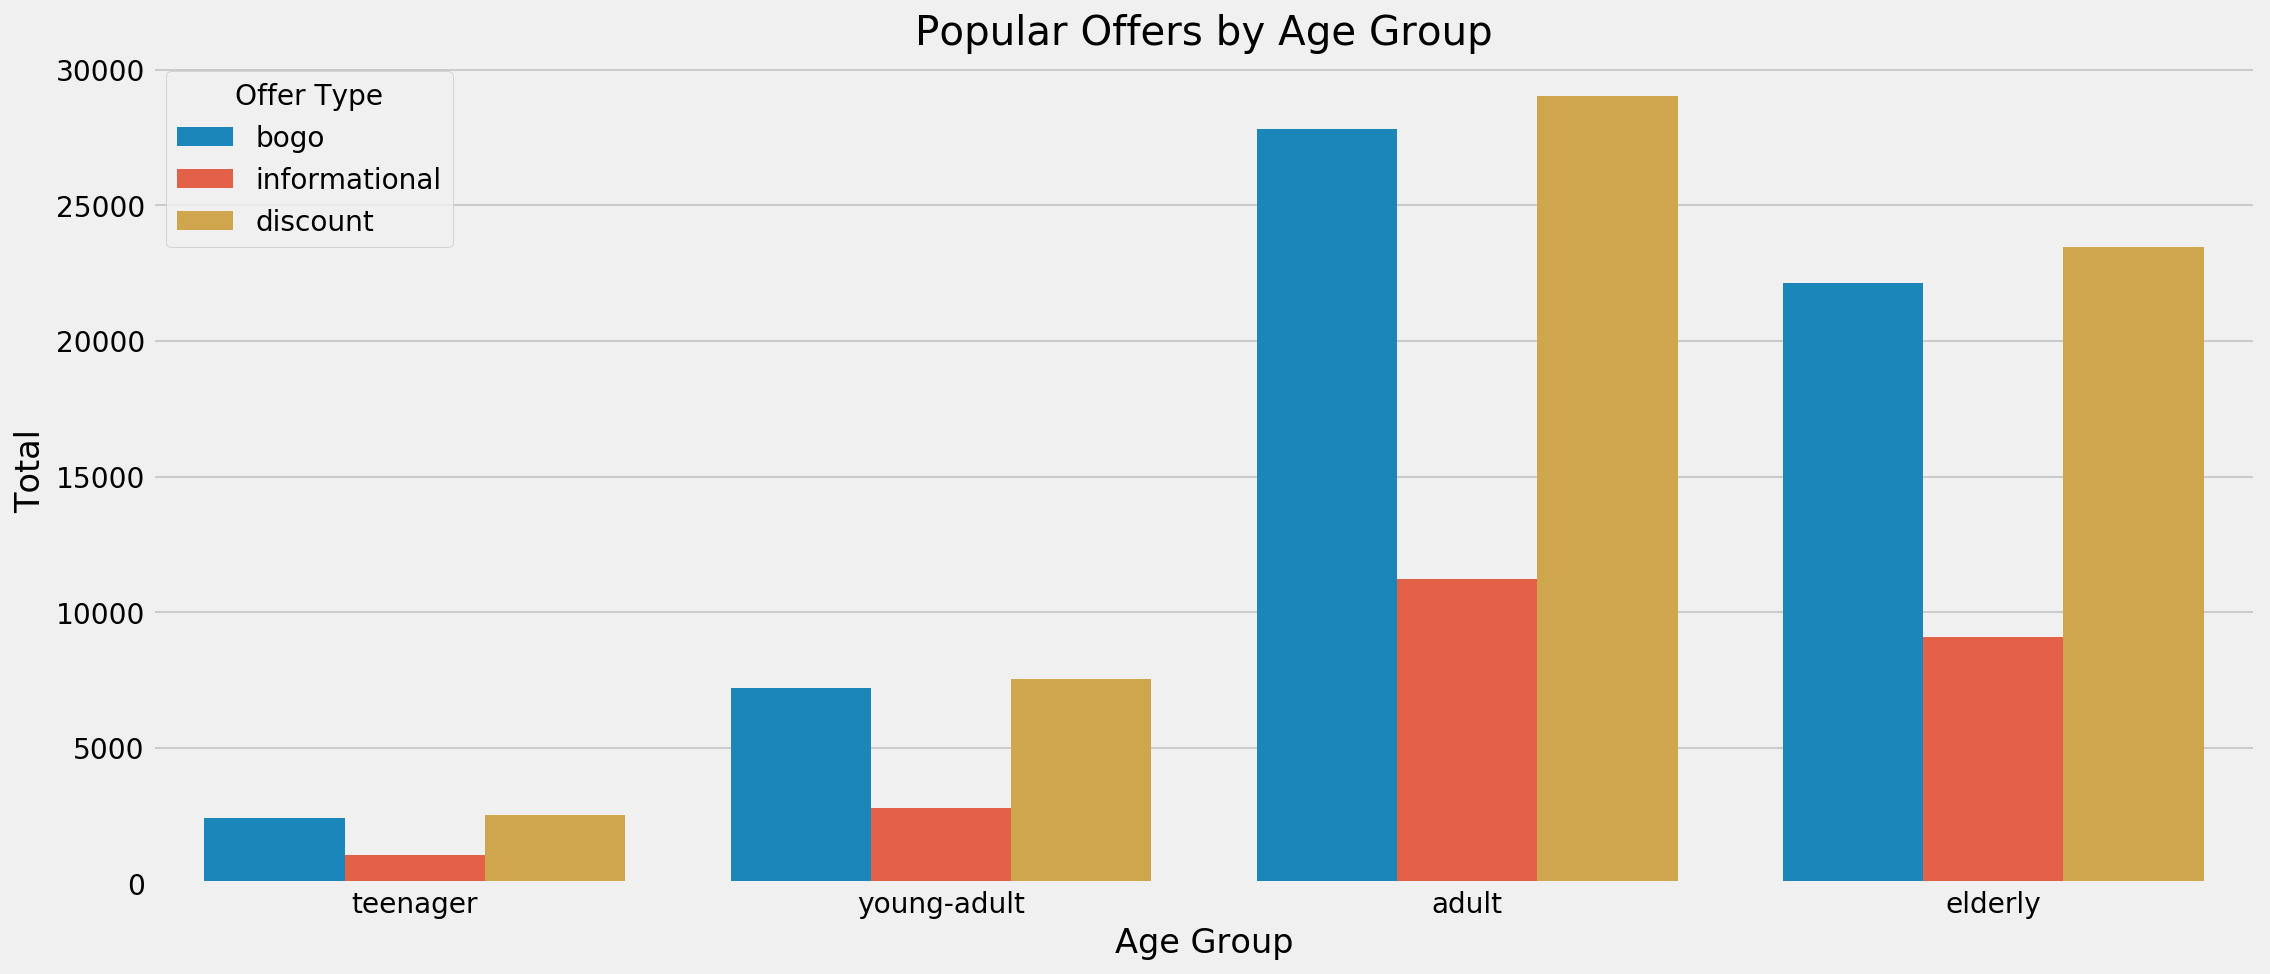

In [104]:
plt.figure(figsize=(16, 7))

plot = sns.countplot(x="age_group", hue="offer_type", data=df)

plt.title('Popular Offers by Age Group')


xlabels = ['teenager','young-adult','adult','elderly']
plt.ylabel('Total')
plt.xlabel('Age Group')
plot.set_xticklabels(xlabels)
plt.xticks(rotation = 0)

plt.legend(title='Offer Type')
plt.tight_layout()
plt.show();

* it seems inforamtional is least popular compared to the two types among all groups
* As For adults it seems discount is more `Popular` 

In [105]:
# letmas see who takes long time in complete an offer
grouped = df.groupby(['gender', 'offer_id'])['time_h'].mean().reset_index()
# filtering by gender
males = grouped.loc[grouped.gender=='M']
females = grouped.loc[grouped.gender=='F']

In [106]:
males.time_h.mean() / 24

14.756849662344854

In [107]:
females.time_h.mean() / 24

14.692737984462312

both Males and Females takes about 14 days to compelet an offer. There is no much difference between them

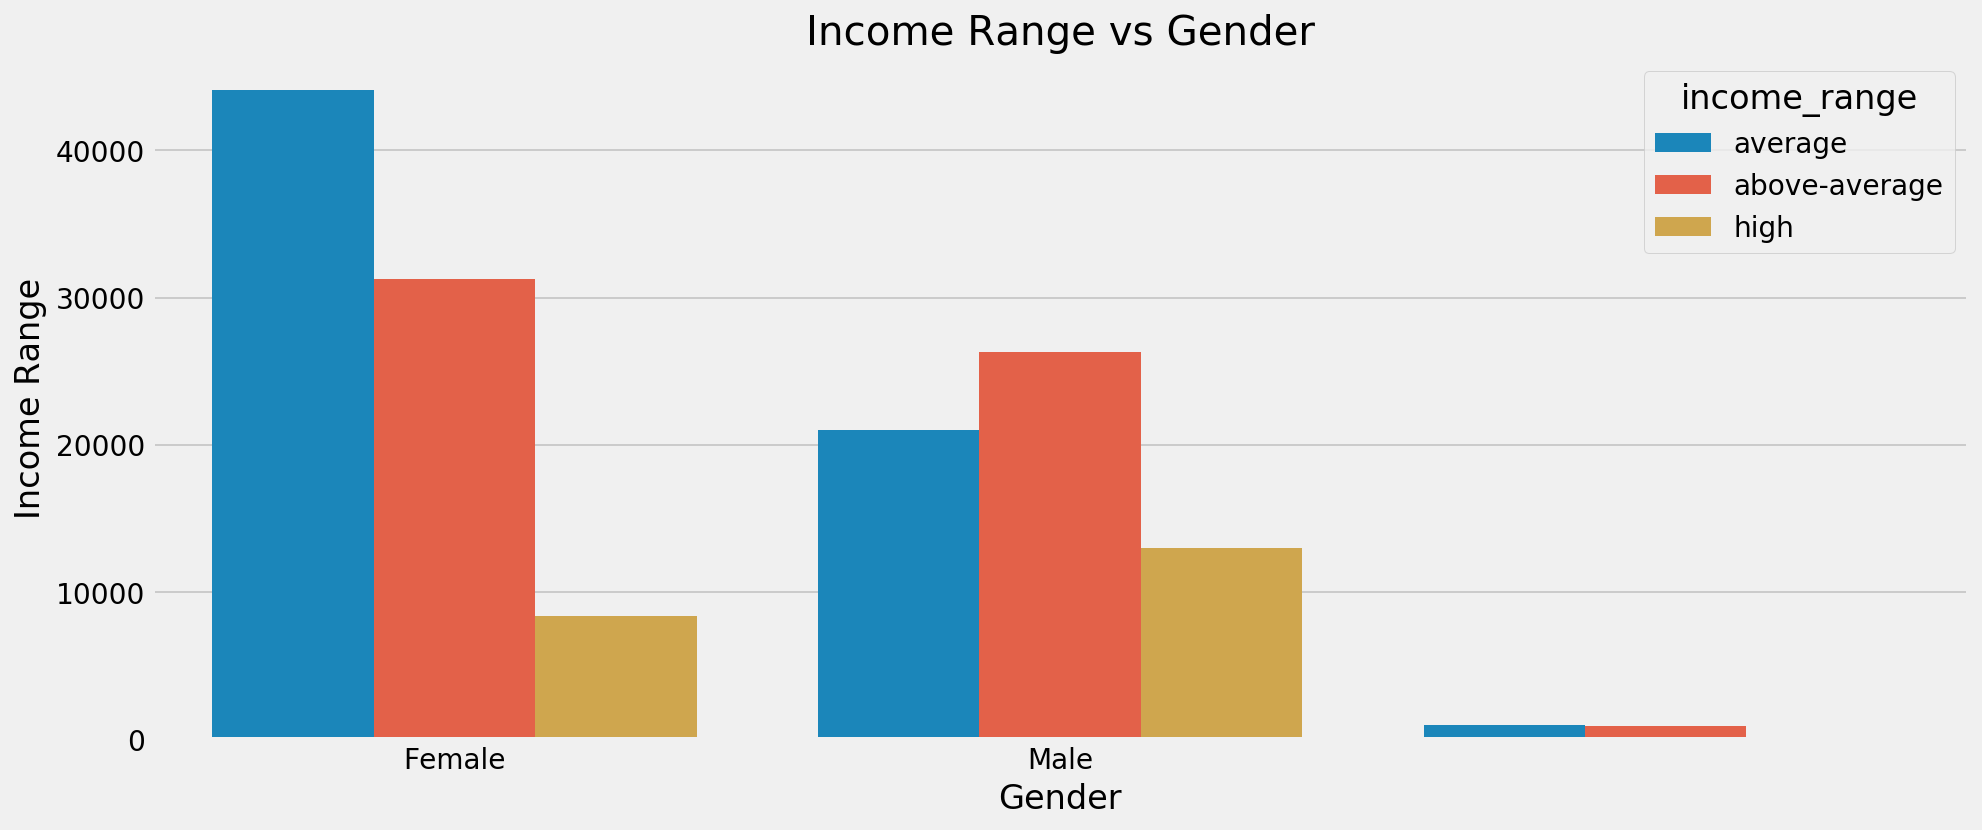

In [108]:
plt.figure(figsize=(14, 6))

plot = sns.countplot(x="gender", hue="income_range", data=df[df["gender"] !=1])
plt.title('Income Range vs Gender')
plt.ylabel('Income Range')
xlabels = ['Female', 'Male']
plot.set_xticklabels(xlabels)
plt.xlabel('Gender')
plt.xticks(rotation = 0)

plt.tight_layout()
plt.show();

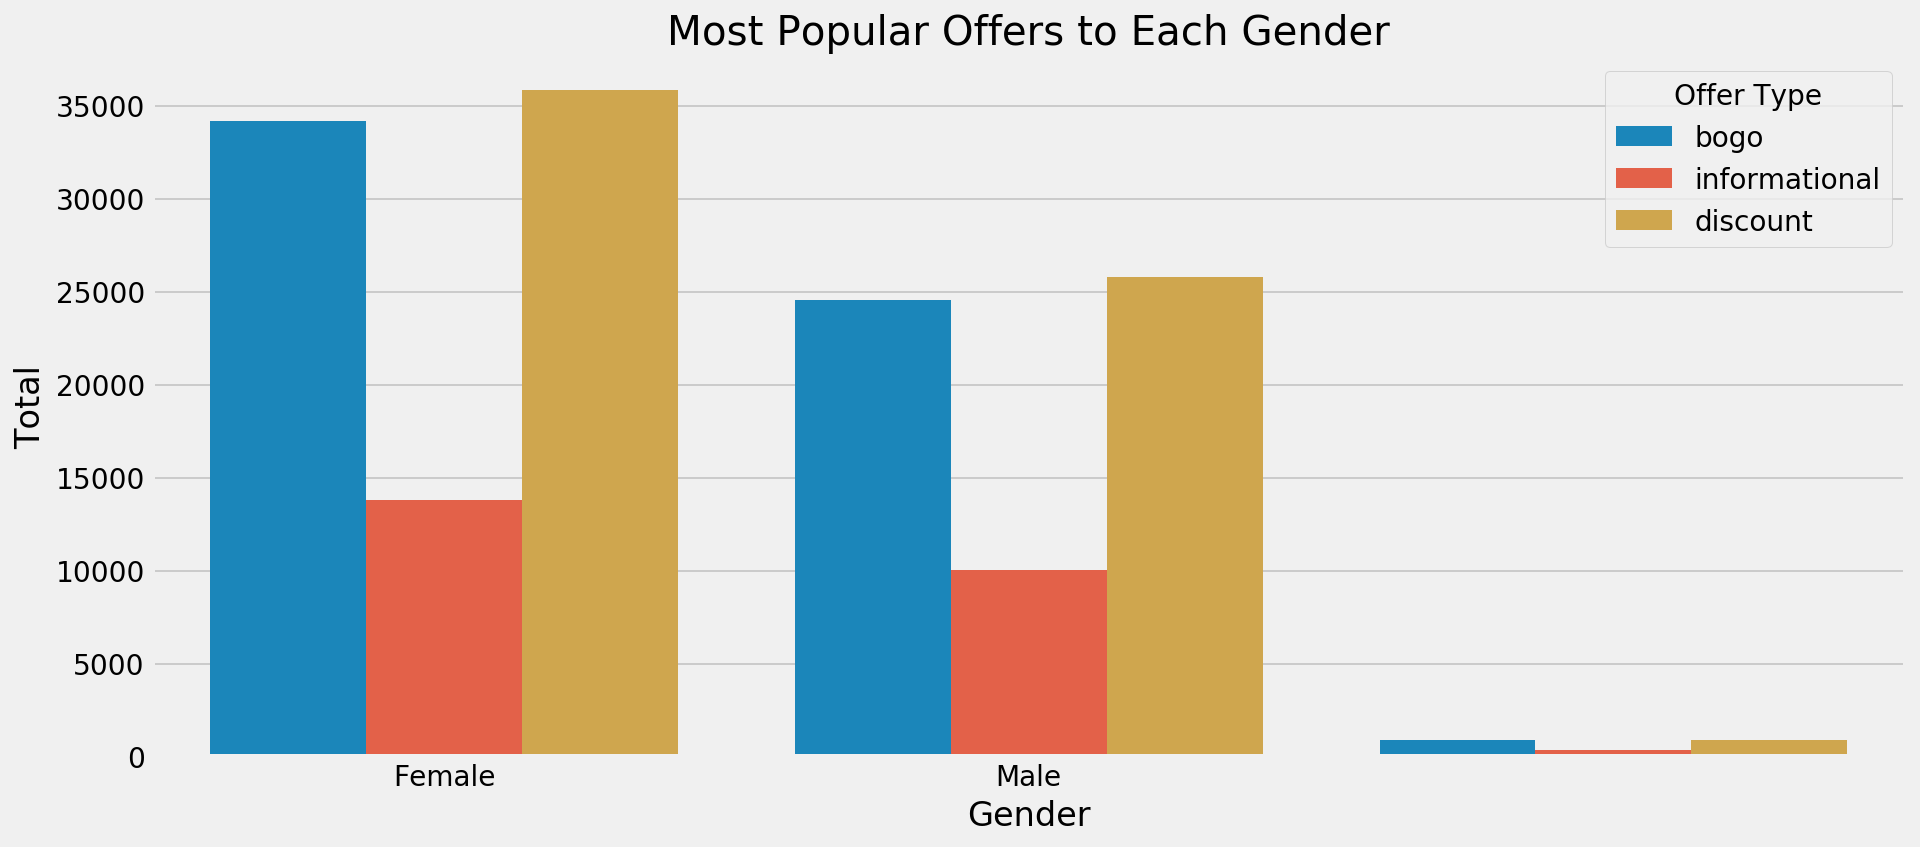

In [109]:
plt.figure(figsize=(14, 6))
plot = sns.countplot(x='gender', hue="offer_type", data= df[df["gender"] !=1])
plt.title('Most Popular Offers to Each Gender')
plt.ylabel('Total')
plt.xlabel('Gender')
xlabels = ['Female', 'Male']
plot.set_xticklabels(xlabels)
plt.legend(title='Offer Type')
plt.show();

In [110]:
# grouping by year to measure income
yearly_grouped = profile_copy.groupby('membership_year').agg({'income': ['sum', 'mean', 'median']}).reset_index()
# yearly_grouped = yearly_grouped.set_index('membership_year')

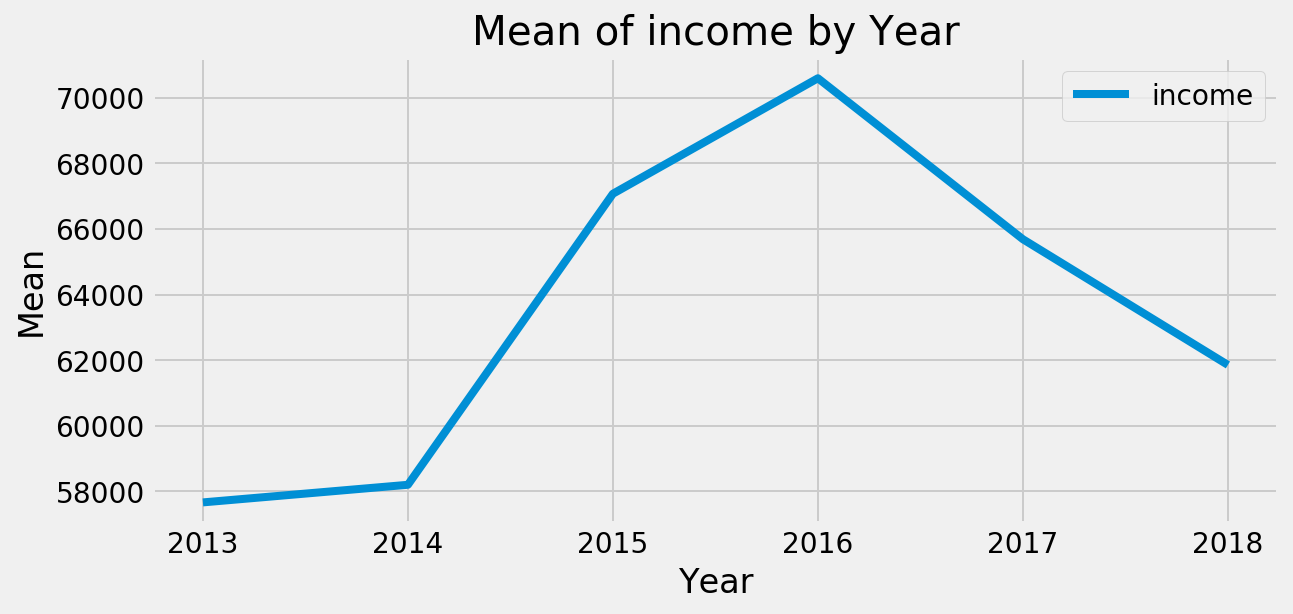

In [117]:
# icnome per year
plt.figure(figsize=(9, 4))
plt.plot(yearly_grouped['membership_year'], yearly_grouped['income']['mean'], label = 'income')

plt.xlabel('Year'); plt.ylabel('Mean'); plt.title('Mean of income by Year')
plt.legend();

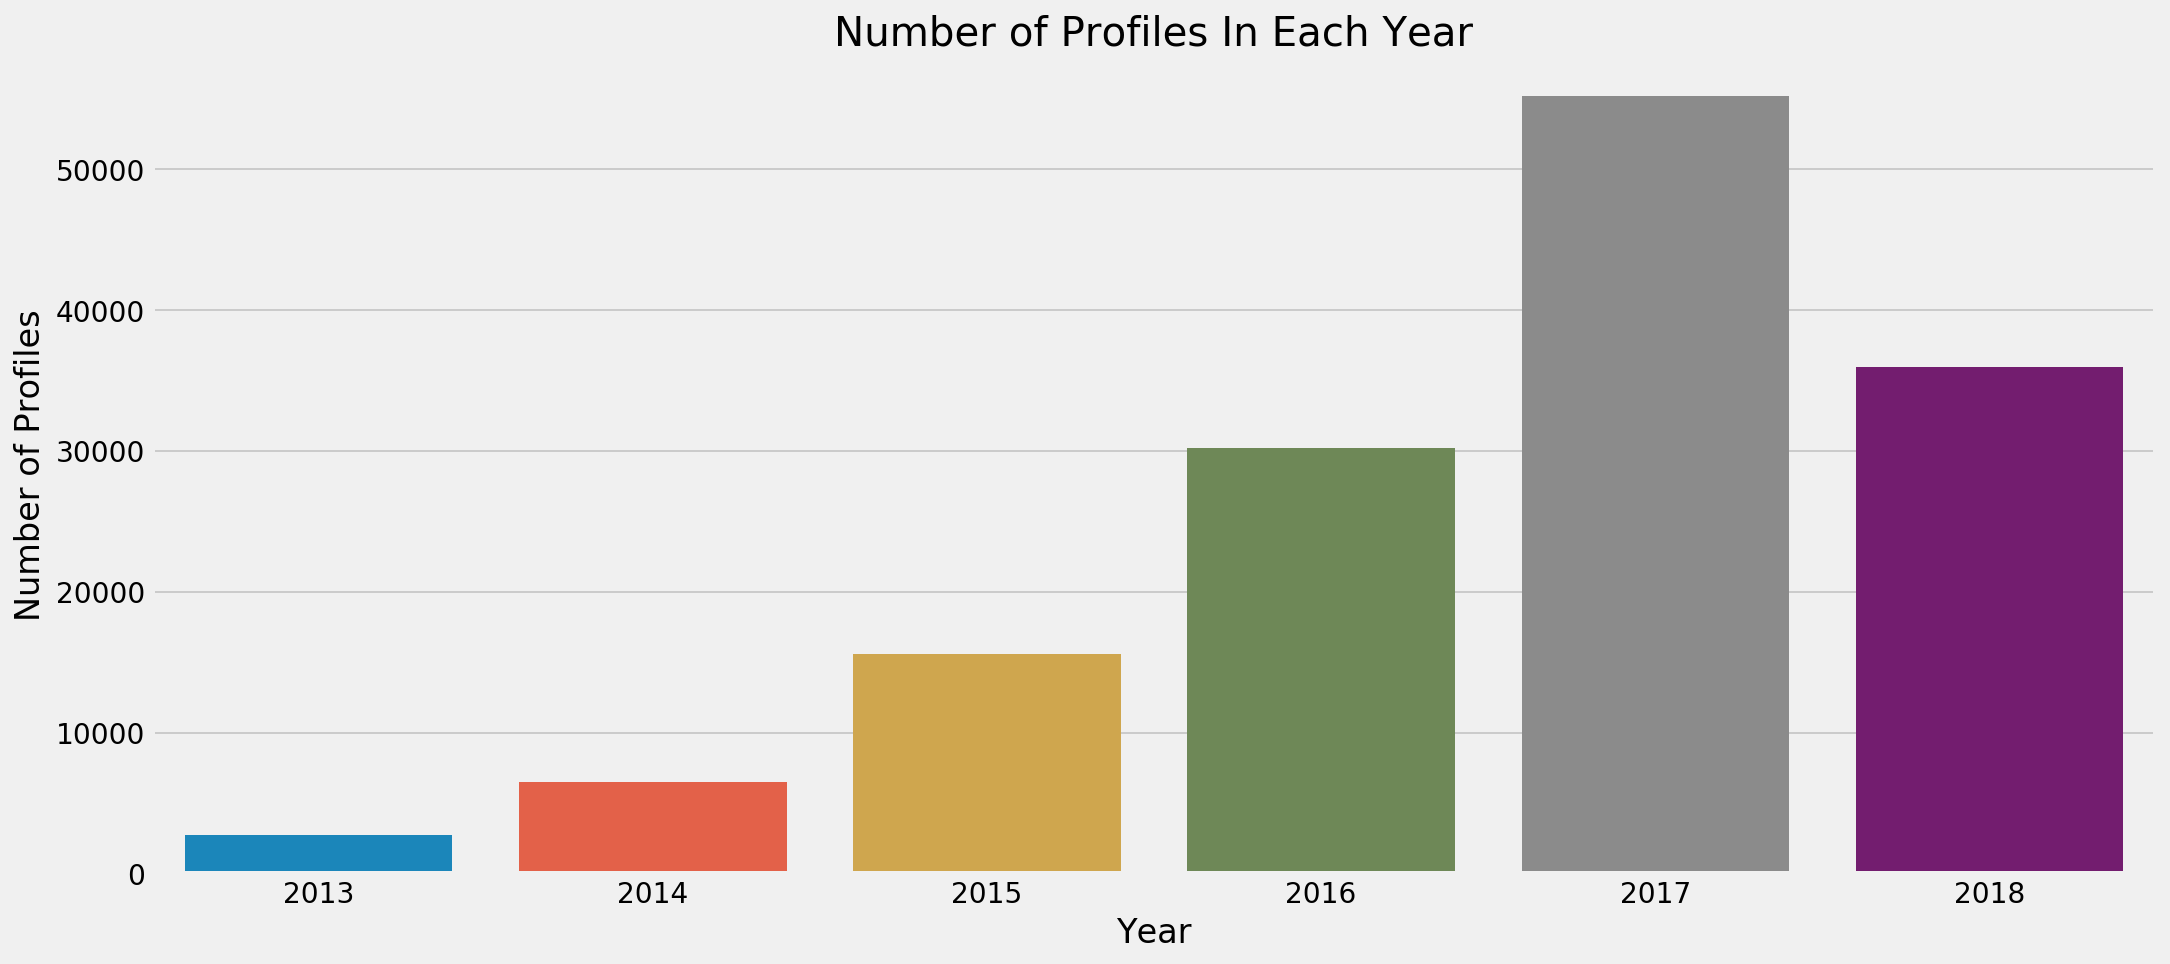

In [132]:
plt.figure(figsize=(16, 7))
sns.countplot(df['membership_year'])
plt.title('Number of Profiles In Each Year')
plt.ylabel('Number of Profiles')
plt.xlabel('Year')
plt.xticks()
plt.show();
%matplotlib inline

In [113]:
# inforamtion about offers completed and viewed
filter_evented = df.loc[(df.event != 'transaction') & (df.event != 'offer viewed')]

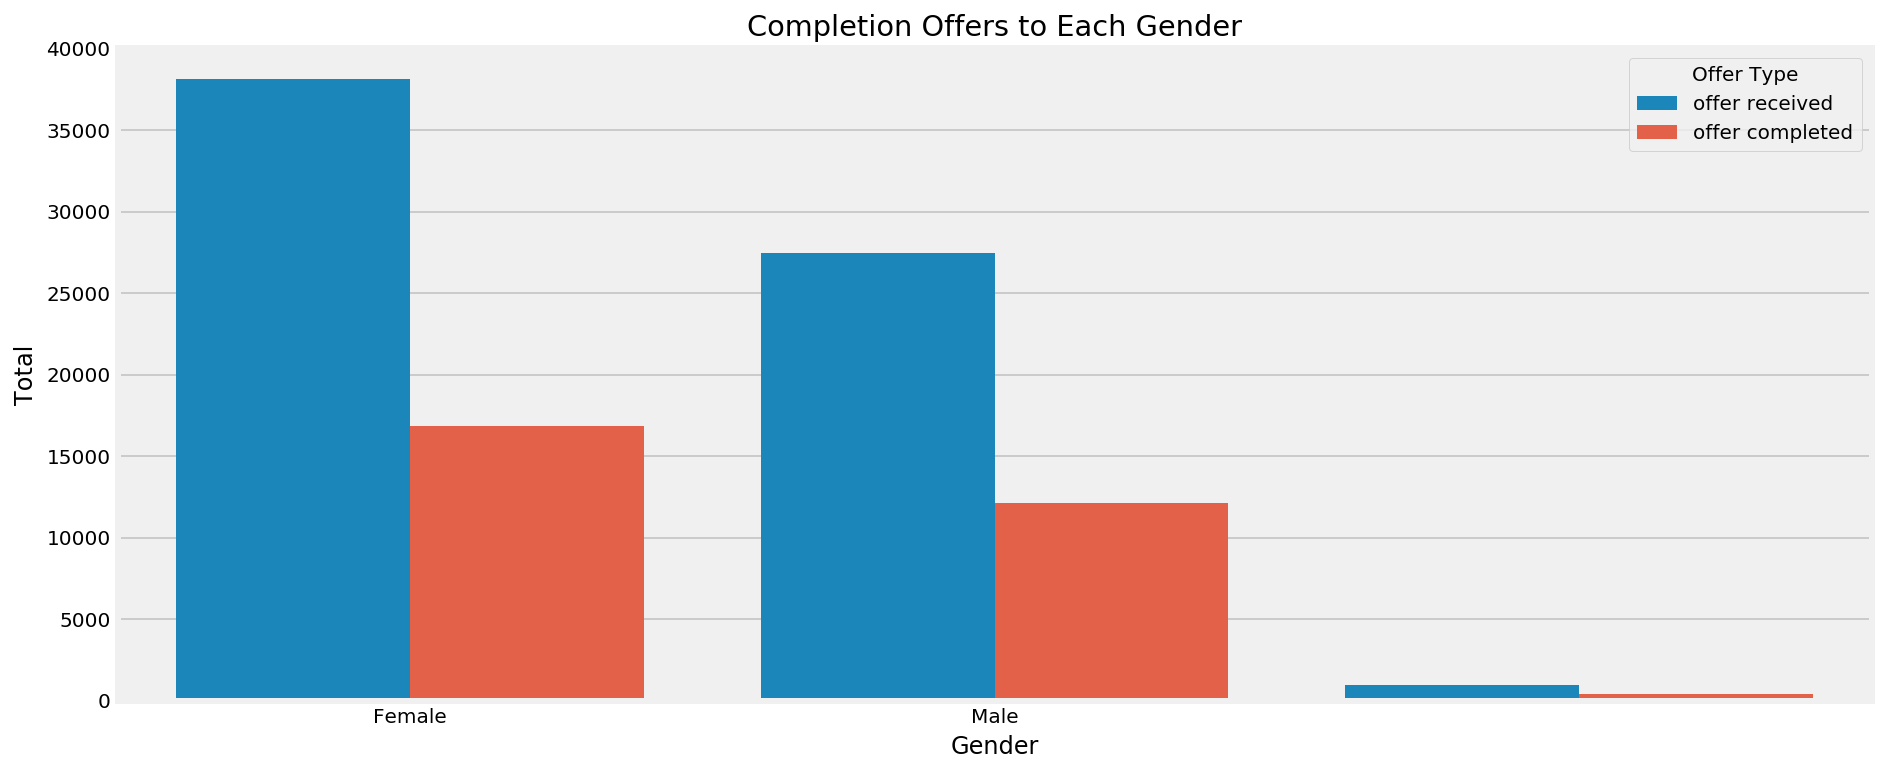

In [135]:

plt.figure(figsize=(14, 6))
g = sns.countplot(x='gender', hue="event", data= filter_evented[filter_evented["gender"] !=1])
plt.title('Completion Offers to Each Gender')
plt.ylabel('Total')
plt.xlabel('Gender')
xlabels = ['Female', 'Male']
g.set_xticklabels(xlabels)
plt.legend(title='Offer Type')
plt.show();

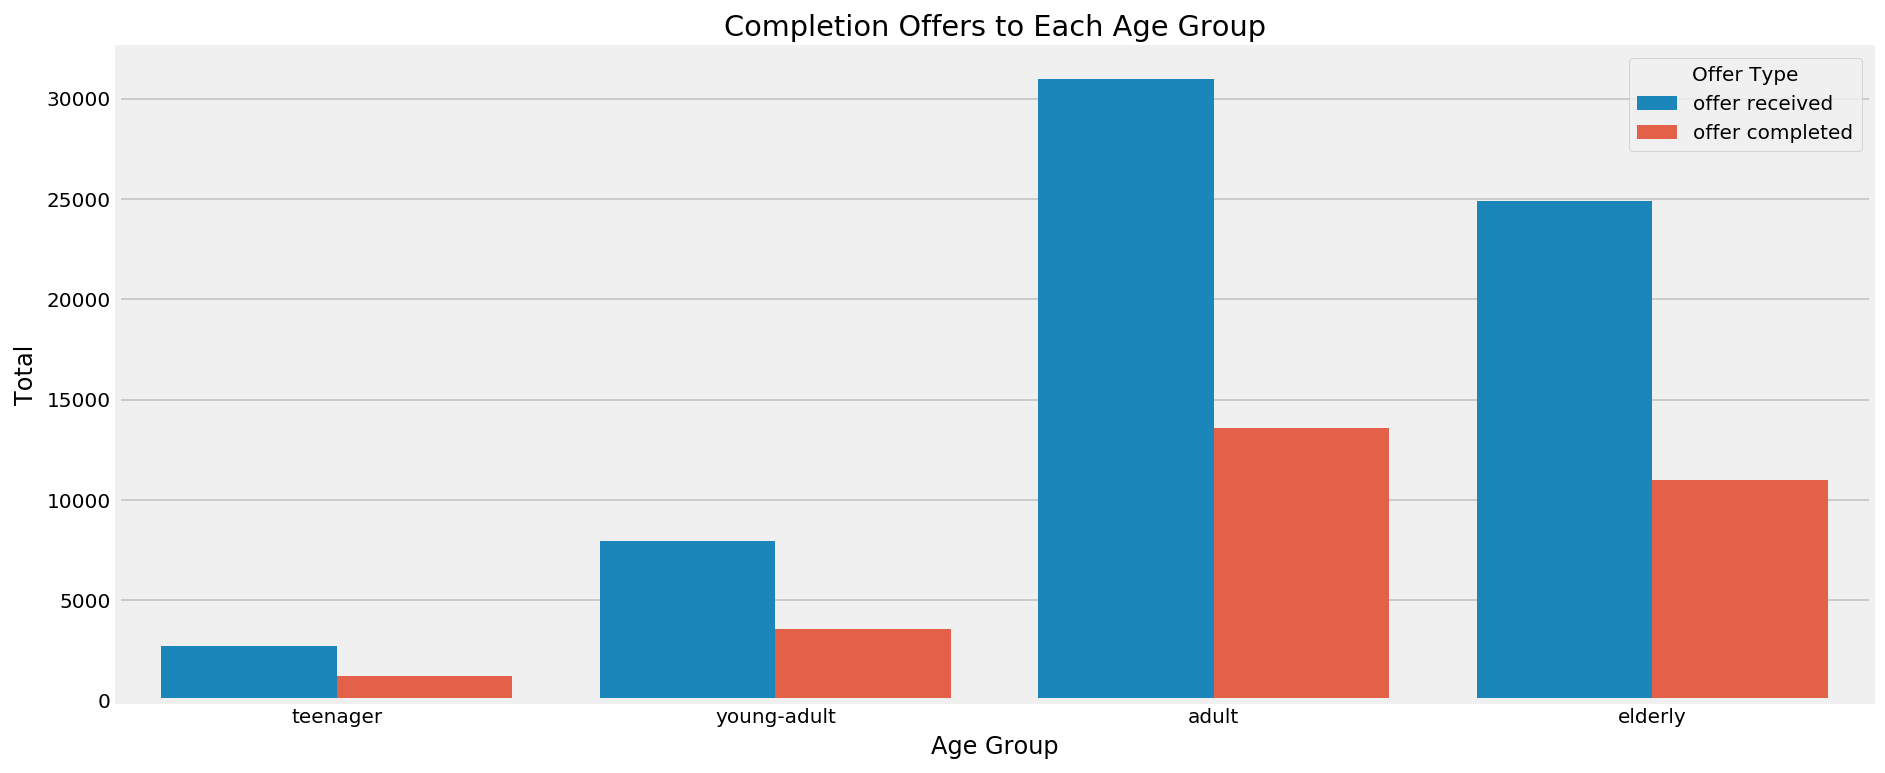

In [138]:

plt.figure(figsize=(14, 6))
g = sns.countplot(x='age_group', hue="event", data= filter_evented[filter_evented["gender"] !=1])
plt.title('Completion Offers to Each Age Group')
plt.ylabel('Total')
plt.xlabel('Age Group')


plt.legend(title='Offer Type')
plt.show();

After we have preprocessed and explored the data now we build the model

my target is to predict Whether a customer will view or completed the offer **[event : completed, or viewd]**

and predictor variables are:

- reward
- offer_id
- member_type
- gender
- difficulty
- duration_h
- offer_type
- time_h
- age
- income
- channel (web, email, mobile, social )


In [115]:
df.columns

Index(['event', 'time_h', 'customer_id', 'amount', 'reward_x', 'offer_id',
       'difficulty', 'duration_h', 'offer_type', 'reward_y', 'web', 'email',
       'mobile', 'social', 'age', 'gender', 'income', 'age_group',
       'income_range', 'membership_year', 'member_type'],
      dtype='object')

In [182]:
df = df.loc[df.event != 'transaction']
df = df.loc[df.event != 'offer received']

In [183]:
df.event.unique()

array(['offer viewed', 'offer completed'], dtype=object)

In [184]:
df.head()

,event,time_h,customer_id,amount,reward_x,offer_id,difficulty,duration_h,offer_type,reward_y,...,email,mobile,social,age,gender,income,age_group,income_range,membership_year,member_type
2,offer viewed,714,19,NaN,NaN,1,10,168,bogo,10,...,1,1,1,57,M,42000.0,adult,average,2017,new
4,offer viewed,420,19,NaN,NaN,3,0,96,informational,0,...,1,1,0,57,M,42000.0,adult,average,2017,new
5,offer completed,432,19,NaN,2.0,3,0,96,informational,0,...,1,1,0,57,M,42000.0,adult,average,2017,new
7,offer viewed,300,19,NaN,NaN,4,5,168,bogo,5,...,1,1,0,57,M,42000.0,adult,average,2017,new
8,offer completed,300,19,NaN,2.0,4,5,168,bogo,5,...,1,1,0,57,M,42000.0,adult,average,2017,new


In [185]:
df.event.value_counts()

offer viewed       50383
offer completed    29379
Name: event, dtype: int64

In [186]:
X = df.drop(columns=['customer_id', 'amount', 'reward_x', 'event', 'customer_id', 'membership_year', 'age_group', 'income_range'])
y = df['event']

In [187]:
X.head()

,time_h,offer_id,difficulty,duration_h,offer_type,reward_y,web,email,mobile,social,age,gender,income,member_type
2,714,1,10,168,bogo,10,0,1,1,1,57,M,42000.0,new
4,420,3,0,96,informational,0,1,1,1,0,57,M,42000.0,new
5,432,3,0,96,informational,0,1,1,1,0,57,M,42000.0,new
7,300,4,5,168,bogo,5,1,1,1,0,57,M,42000.0,new
8,300,4,5,168,bogo,5,1,1,1,0,57,M,42000.0,new


In [188]:
y.shape, X.shape

((79762,), (79762, 14))

In [189]:
y = y.map({'offer completed': 1, 'offer viewed': 0})

In [190]:
y.value_counts()

0    50383
1    29379
Name: event, dtype: int64

In [191]:
X_scaled = X.copy()

In [192]:
# scaling numerical features
scaler = StandardScaler()

In [193]:
numerical = ['time_h', 'duration_h', 'reward_y', 'difficulty']
X_scaled[numerical] = scaler.fit_transform(X_scaled[numerical])
X_scaled.head(2)

,time_h,offer_id,difficulty,duration_h,offer_type,reward_y,web,email,mobile,social,age,gender,income,member_type
2,1.729199,1,0.337669,0.025436,bogo,1.896400,0,1,1,1,57,M,42000.0,new
4,0.244253,3,-1.510106,-1.384102,informational,-1.397919,1,1,1,0,57,M,42000.0,new


In [194]:
# hot encoding 
X_scaled_encoded = pd.get_dummies(X_scaled)

In [195]:
X_scaled_encoded.head(2)

,time_h,offer_id,difficulty,duration_h,reward_y,web,email,mobile,social,age,income,offer_type_bogo,offer_type_discount,offer_type_informational,gender_F,gender_M,gender_O,member_type_new,member_type_regular,member_type_loyal
2,1.729199,1,0.337669,0.025436,1.896400,0,1,1,1,57,42000.0,1,0,0,0,1,0,1,0,0
4,0.244253,3,-1.510106,-1.384102,-1.397919,1,1,1,0,57,42000.0,0,0,1,0,1,0,1,0,0


In [196]:
y.isna().sum(), y.shape

(0, (79762,))

In [197]:
# splitting the into trainig set and tet
X_train, X_test, y_train, y_test = train_test_split(X_scaled_encoded, y, random_state=42)

In [198]:
clf = RandomForestClassifier(n_estimators=45, n_jobs=-1, verbose=1)

In [199]:
clf.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    5.1s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=45, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)

In [200]:
rfc_pre = clf.predict(X_test)

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:    0.4s finished


In [204]:
rfc_acc = accuracy_score(y_test, rfc_pre)
rfc_acc

0.54480718118449423

In [681]:
print(classification_report(y_test, y_pre))

             precision    recall  f1-score   support

          0       0.63      0.68      0.66     12642
          1       0.37      0.32      0.34      7299

avg / total       0.54      0.55      0.54     19941



In [726]:
feature_imp = {}
for feature, imp in zip(X.columns, clf.feature_importances_):
    feature_imp[feature] = imp

In [727]:
feature_imp = pd.DataFrame.from_dict(feature_imp, orient='index', columns=['feature_importance'])

In [728]:
feature_imp.sort_values(by='feature_importance', ascending=False)[:15]

,feature_importance
time_h,0.400736
age,0.243621
social,0.237320
offer_id,0.037828
duration_h,0.020771
offer_type,0.009722
mobile,0.007394
income,0.006858
difficulty,0.006693
reward_y,0.005429


I will use the first 3 features to see if it improves the accuracy

In [685]:
X_copy = X_scaled_encoded.copy()

In [686]:
X_copy = X_copy[['time_h', 'age', 'social']]

In [687]:
X_copy.shape

(79762, 3)

In [729]:
X_train, X_test, y_train, y_test = train_test_split(X_copy, y, random_state=42)

In [730]:
clf = RandomForestClassifier(n_estimators=100, n_jobs=-1, verbose=1)
clf.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    8.2s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)

In [731]:
new_feat_pre = clf.predict(X_test)

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.7s finished


In [732]:
print(classification_report(y_test, new_feat_pre))

             precision    recall  f1-score   support

          0       0.68      0.78      0.72     12642
          1       0.48      0.36      0.41      7299

avg / total       0.61      0.63      0.61     19941



In [733]:
accuracy_score(y_test, new_feat_pre)

0.62564565468130984

In [431]:
# grid searching to find the optimal parameters
param_grid = {
    'n_estimators': [110, 125],
    'max_depth': [12, 10, 15],
    'min_samples_split': [5, 7, 9],
    'min_samples_leaf': [2, 4, 7]
    
}

grid_clf = GridSearchCV(clf, param_grid = param_grid,)
grid_clf.fit(X_train, y_train)


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.7s finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:    3.4s finished
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:    3.4s finished
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.3s finished
[Parallel(n_job

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [100, 125], 'max_depth': [12, 10, 15], 'min_samples_split': [5, 7, 9], 'min_samples_leaf': [2, 4, 7]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [432]:
grid_pred = grid_clf.predict(X_test)

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished


In [433]:
print(classification_report(y_test, grid_pred))

             precision    recall  f1-score   support

          0       0.73      0.82      0.77     12642
          1       0.61      0.48      0.54      7299

avg / total       0.69      0.70      0.69     19941



In [438]:
accuracy_score(y_test, grid_pred)

0.69610350534075527

In [216]:
def modeling(clf):
    """model building and training helper
    INPUT:
    
    clf: str. classifier to be used
    
    OUTPUT:
    training error
    testing error
    """
    
    clf = clf()
    clf.fit(X_train, y_train)
    training_acc = accuracy_score(y_train, clf.predict(X_train))
    testing_acc = accuracy_score(y_test, clf.predict(X_test))
    
    return training_acc, testing_acc

In [219]:
knc_train_err, knc_test_err = modeling(KNeighborsClassifier)

In [222]:
gnv_train_err, gnv_test_err = modeling(GaussianNB)

In [223]:
log_train_err, log_test_err = modeling(LogisticRegression)

In [224]:
rf_train_err, rf_test_err = modeling(RandomForestClassifier)

In [247]:
train_score = pd.DataFrame([knc_train_err, gnv_train_err, log_train_err, rf_train_err], index=['KNeighboursClassifier', 'GaussianNB', 'LogisticRegression', 'RandomForestClassifier'], columns=['training_score'])
test_score = pd.DataFrame([knc_test_err, gnv_test_err, log_test_err, rf_test_err], index=['KNeighboursClassifier', 'GaussianNB', 'LogisticRegression', 'RandomForestClassifier'], columns=['test_score'])

In [257]:
train_score['test_score'] = test_score

In [258]:
train_score

,training_score,test_score
KNeighboursClassifier,0.697665,0.512713
GaussianNB,0.634593,0.633770
LogisticRegression,0.637702,0.637681
RandomForestClassifier,0.949265,0.556442


In [270]:
param_grid={"C":np.logspace(-1,4,7), 
            "penalty":["l1","l2"], 
            'max_iter': [100, 110]}
log_clf = LogisticRegression()
grid_clf = GridSearchCV(log_clf, param_grid = param_grid)
grid_clf.fit(X_train, y_train)
grid_train_err = accuracy_score(y_train, grid_clf.predict(X_train))
grid_test_err = accuracy_score(y_test, grid_clf.predict(X_test))

In [271]:
grid_train_err, grid_test_err

(0.65151033917854939, 0.65147184193370444)

In [273]:
grid_clf.best_params_

{'C': 215.44346900318845, 'max_iter': 100, 'penalty': 'l1'}

In [272]:
# params = {'n_neighbors':[5,6,7,8,9,10],
#           'leaf_size':[1,2,3,5],
#           'weights':['uniform', 'distance'],
#           'algorithm':['auto', 'ball_tree','kd_tree','brute'],
#           'n_jobs':[-1]}

# knc_clf = KNeighborsClassifier()
# knc_clf_gird = GridSearchCV(knc_clf, param_grid = params)
# knc_clf_gird.fit(X_train, y_train)
# knc_clf_gird_train_err = accuracy_score(y_train, knc_clf_gird.predict(X_train))
# knc_clf_gird_test_err = accuracy_score(y_test, knc_clf_gird.predict(X_test))

In [ ]:
# knc_clf_gird_train_err, knc_clf_gird_test_err